# Results for predicates planning and ViLa planning

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
print("ROOT", ROOT)

ROOT /scratch/cs/world-models/merlerm1/open-world-symbolic-planner


In [2]:
sys.path.append(ROOT)

In [3]:
experiment_folder = os.path.join(ROOT, 'results', 'planning', 'blocksworld', 'run_16_04_25')
assert os.path.exists(experiment_folder), f"Experiment folder {experiment_folder} does not exist"

predicates_folder = os.path.join(experiment_folder, 'predicates')
vila_folder = os.path.join(experiment_folder, 'vila')
assert os.path.exists(predicates_folder), f"Predicates folder {predicates_folder} does not exist"
assert os.path.exists(vila_folder), f"Vila folder {vila_folder} does not exist"

# List the content of the predicates folder
splits = os.listdir(predicates_folder)
assert len(splits) > 0, f"No splits found in {predicates_folder}"
assert splits == os.listdir(vila_folder), f"Predicates and Vila folders do not match: {predicates_folder} vs {vila_folder}"
splits.sort(reverse=True)
print("Splits:", splits)

Splits: ['simple', 'medium', 'hard']


In [4]:
def load_results(folder):
    """
    Load the results from a folder.
    """
    results = defaultdict(dict)
    for split in splits:
        results[split] = defaultdict(dict)
        split_folder = os.path.join(folder, split)
        if not os.path.exists(split_folder):
            print(f"Split folder {split_folder} does not exist")
            continue
        models = os.listdir(split_folder)
        for model in models:
            model_folder = os.path.join(split_folder, model)
            print(f"Loading {model_folder}")
            contents = os.listdir(model_folder)
            if len(contents) == 0:
                print(f"Model folder {model_folder} is empty")
                continue
            if len(contents) > 1:
                print(f"Model folder {model_folder} has more than one file, defaulting to most recent")
            
            results_file = os.path.join(model_folder, sorted(contents)[-1])
            with open(results_file, 'r') as f:
                data = json.load(f)
            results[split][model] = data
    return results

In [5]:
predicates_results = load_results(predicates_folder)
print()
vila_results = load_results(vila_folder)

Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_16_04_25/predicates/simple/InternVL3-8B
Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_16_04_25/predicates/simple/gpt-4.1
Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_16_04_25/predicates/simple/gemma-3-12b-it
Model folder /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_16_04_25/predicates/simple/gemma-3-12b-it has more than one file, defaulting to most recent
Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_16_04_25/predicates/simple/gemma-3-27b-it
Model folder /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_16_04_25/predicates/simple/gemma-3-27b-it has more than one file, defaulting to most recent
Loading /scratch/cs/world-mod

## Predicates

In [6]:
def list_models(results):
    """
    List the models in the results.
    """
    models = {split: set() for split in splits}
    for split in splits:
        for model in results[split]:
            models[split].add(model)
            
    # Compare the models across splits and print if some are missing
    for split in splits:
        for other_split in splits:
            if split == other_split:
                continue
            missing_models = models[split] - models[other_split]
            if len(missing_models) > 0:
                print(f"Missing models in {other_split} compared to {split}: {missing_models}")
    return models

predicates_models = list_models(predicates_results)
predicates_models

{'simple': {'InternVL3-8B',
  'Mistral-Small-3.1-24B-Instruct-2503',
  'Molmo-72B-0924',
  'Molmo-7B-D-0924',
  'Phi-4-multimodal-instruct',
  'Qwen2.5-VL-72B-Instruct',
  'Qwen2.5-VL-7B-Instruct',
  'aya-vision-32b',
  'aya-vision-8b',
  'deepseek-vl2',
  'gemma-3-12b-it',
  'gemma-3-27b-it',
  'gpt-4.1',
  'gpt-4.1-nano',
  'llava-onevision-qwen2-72b-ov-hf',
  'llava-onevision-qwen2-7b-ov-hf'},
 'medium': {'InternVL3-8B',
  'Mistral-Small-3.1-24B-Instruct-2503',
  'Molmo-72B-0924',
  'Molmo-7B-D-0924',
  'Phi-4-multimodal-instruct',
  'Qwen2.5-VL-72B-Instruct',
  'Qwen2.5-VL-7B-Instruct',
  'aya-vision-32b',
  'aya-vision-8b',
  'deepseek-vl2',
  'gemma-3-12b-it',
  'gemma-3-27b-it',
  'gpt-4.1',
  'gpt-4.1-nano',
  'llava-onevision-qwen2-72b-ov-hf',
  'llava-onevision-qwen2-7b-ov-hf'},
 'hard': {'InternVL3-8B',
  'Mistral-Small-3.1-24B-Instruct-2503',
  'Molmo-72B-0924',
  'Molmo-7B-D-0924',
  'Phi-4-multimodal-instruct',
  'Qwen2.5-VL-72B-Instruct',
  'Qwen2.5-VL-7B-Instruct',
  'a

In [7]:
def construct_main_table(results):
    """
    Given a nested dict results[split][model] = data,
    returns a DataFrame with columns:
      model, split, task accuracy, action accuracy,
      enumeration accuracy, failed problems
    """
    rows = []
    for split in splits:
        for model, data in results.get(split, {}).items():
            # Safely round metrics, leaving NaN as is
            ta = results.get(split, {})[model].get('task_accuracy', np.nan)
            aa = results.get(split, {})[model].get('action_accuracy', np.nan)
            ea = results.get(split, {})[model].get('enumeration_accuracy', np.nan)
            rows.append({
                'model': model,
                'split': split,
                'task accuracy': np.nan if pd.isna(ta) else round(ta, 2),
                'action accuracy': np.nan if pd.isna(aa) else round(aa, 2),
                'enumeration accuracy': np.nan if pd.isna(ea) else round(ea, 2),
                'failed problems': len(data.get('failed_problems', []))
            })
    df = pd.DataFrame(rows)
    df['split'] = pd.Categorical(df['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df = df.sort_values(by=['model', 'split'])
    return df

predicates_main_table = construct_main_table(predicates_results)
predicates_main_table

model   split  task accuracy  \
0                          InternVL3-8B  simple            0.0   
16                         InternVL3-8B  medium            0.0   
32                         InternVL3-8B    hard            0.0   
13  Mistral-Small-3.1-24B-Instruct-2503  simple            0.4   
29  Mistral-Small-3.1-24B-Instruct-2503  medium            0.0   
45  Mistral-Small-3.1-24B-Instruct-2503    hard            0.0   
14                       Molmo-72B-0924  simple            0.0   
30                       Molmo-72B-0924  medium            0.0   
46                       Molmo-72B-0924    hard            0.0   
12                      Molmo-7B-D-0924  simple            0.2   
28                      Molmo-7B-D-0924  medium            0.0   
44                      Molmo-7B-D-0924    hard            0.0   
8             Phi-4-multimodal-instruct  simple            0.0   
24            Phi-4-multimodal-instruct  medium            0.0   
40            Phi-4-multimodal-instruct    hard            0.0   
5               Qwen2.5-VL-72B-Instruct  simple            0.6   
21              Qwen2.5-VL-72B-Instruct  medium            0.3   
37              Qwen2.5-VL-72B-Instruct    hard            0.0   
9                Qwen2.5-VL-7B-Instruct  simple            0.5   
25               Qwen2.5-VL-7B-Instruct  medium            0.0   
41               Qwen2.5-VL-7B-Instruct    hard            0.0   
7                        aya-vision-32b  simple            0.0   
23                       aya-vision-32b  medium            0.0   
39                       aya-vision-32b    hard            0.0   
11                        aya-vision-8b  simple            0.0   
27                        aya-vision-8b  medium            0.0   
43                        aya-vision-8b    hard            0.0   
10                         deepseek-vl2  simple            0.0   
26                         deepseek-vl2  medium            0.0   
42                         deepseek-vl2    hard            0.0   
2                        gemma-3-12b-it  simple            0.1   
18                       gemma-3-12b-it  medium            0.0   
34                       gemma-3-12b-it    hard            0.0   
3                        gemma-3-27b-it  simple            0.0   
19                       gemma-3-27b-it  medium            0.0   
35                       gemma-3-27b-it    hard            0.0   
1                               gpt-4.1  simple            0.8   
17                              gpt-4.1  medium            0.4   
33                              gpt-4.1    hard            0.1   
6                          gpt-4.1-nano  simple            0.1   
22                         gpt-4.1-nano  medium            0.0   
38                         gpt-4.1-nano    hard            0.0   
15      llava-onevision-qwen2-72b-ov-hf  simple            0.0   
31      llava-onevision-qwen2-72b-ov-hf  medium            0.0   
47      llava-onevision-qwen2-72b-ov-hf    hard            0.0   
4        llava-onevision-qwen2-7b-ov-hf  simple            0.0   
20       llava-onevision-qwen2-7b-ov-hf  medium            0.0   
36       llava-onevision-qwen2-7b-ov-hf    hard            0.0   

    action accuracy  enumeration accuracy  failed problems  
0              0.27                  0.97                4  
16             0.02                  0.96                2  
32             0.01                  0.93                3  
13             0.55                  0.99                3  
29             0.07                  0.96                9  
45             0.07                  0.95                7  
14             0.00                   NaN               10  
30             0.00                   NaN               10  
46             0.00                   NaN               10  
12             0.40                  0.96                2  
28             0.27                  0.95                1  
44             0.18                  0.93                1  
8     

/tmp/ipykernel_2115318/3050156804.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/3050156804.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/3050156804.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


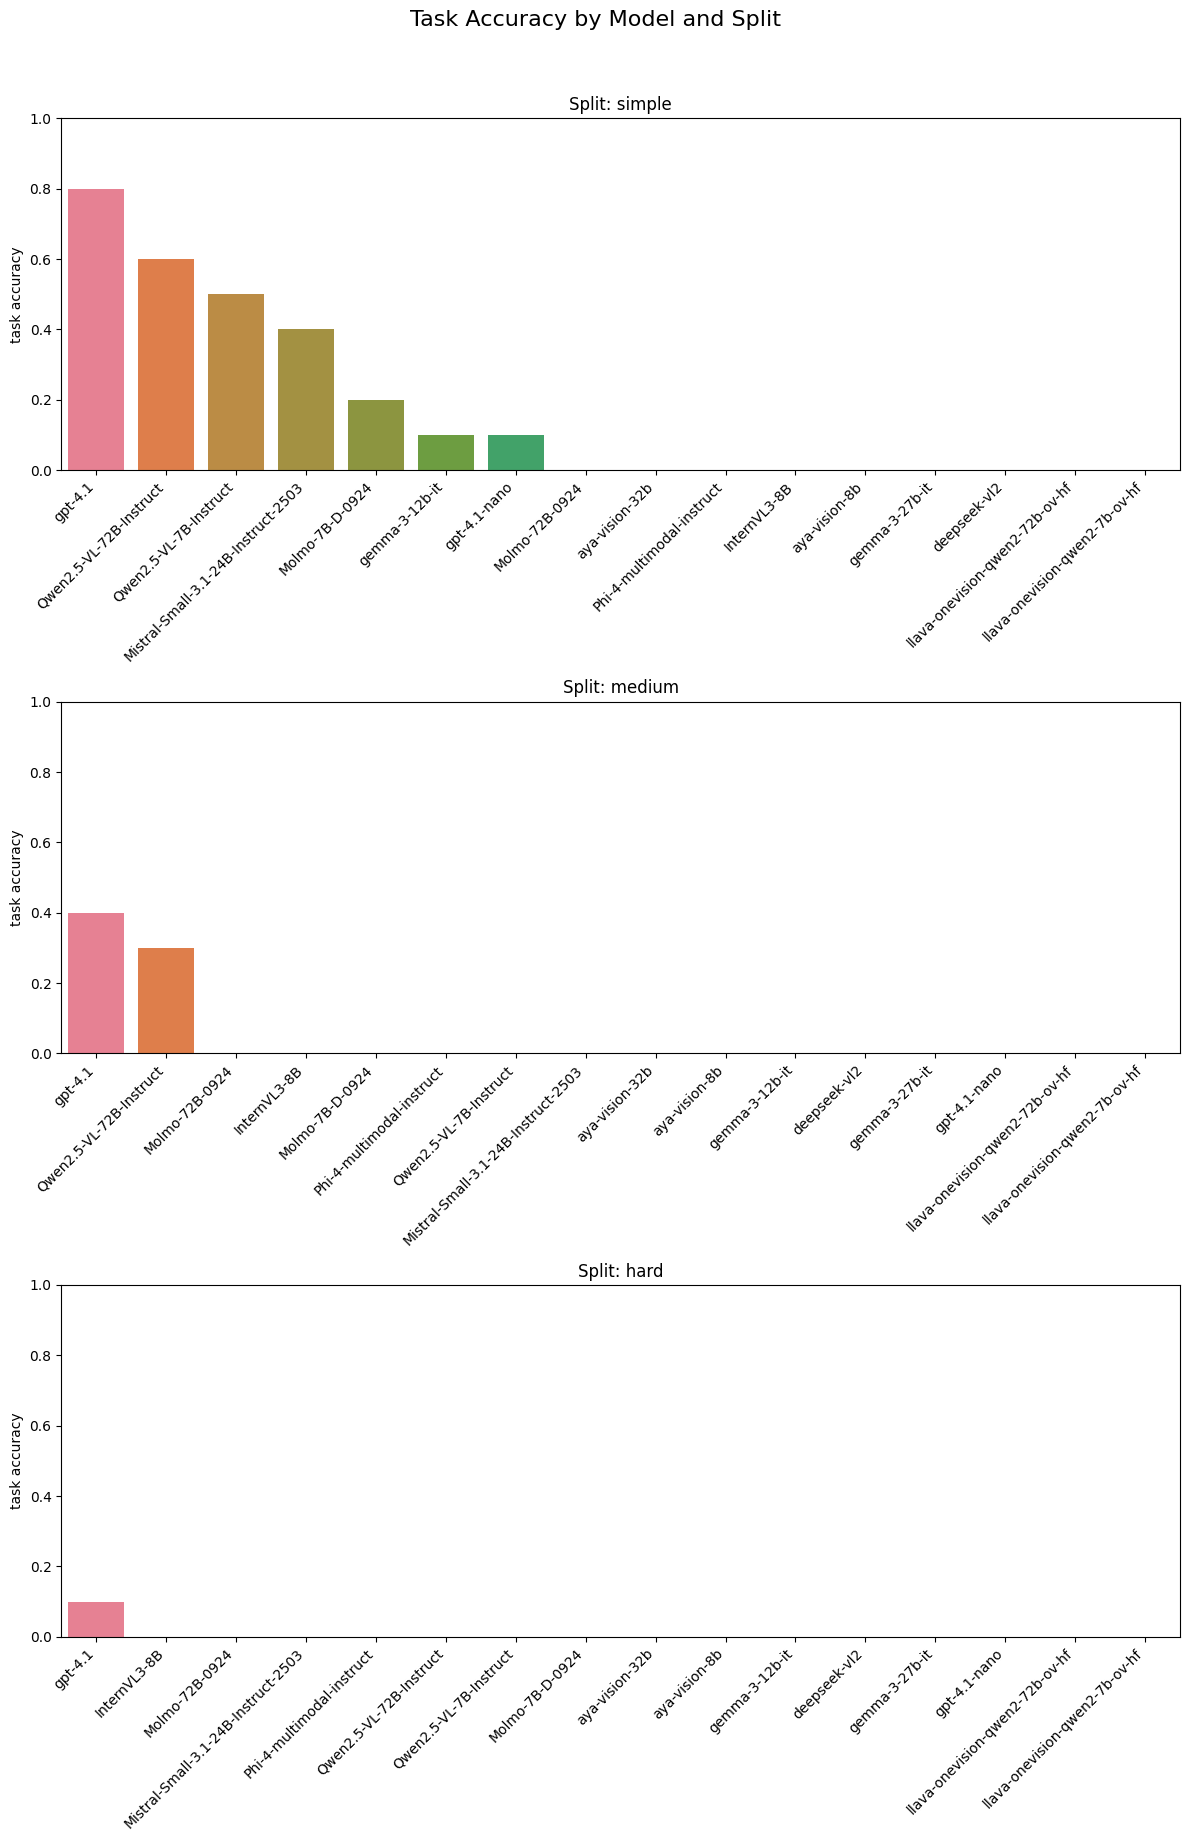

In [8]:
def plot_task_accuracy_bar(main_table):
    """
    Plot a 3×1 grid of barplots for task accuracy by model,
    one subplot per split, sorted descending.
    """
    fig, axes = plt.subplots(len(splits), 1, figsize=(12, 18), sharey=True)
    for ax, split in zip(axes, splits):
        df_split = main_table[main_table['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue
        df_sorted = df_split.sort_values('task accuracy', ascending=False)
        sns.barplot(
            data=df_sorted,
            x='model', y='task accuracy',
            hue='model',
            ax=ax
        )
        ax.set_title(f"Split: {split}")
        ax.set_ylim(0, 1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    fig.suptitle("Task Accuracy by Model and Split", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_task_accuracy_bar(predicates_main_table)


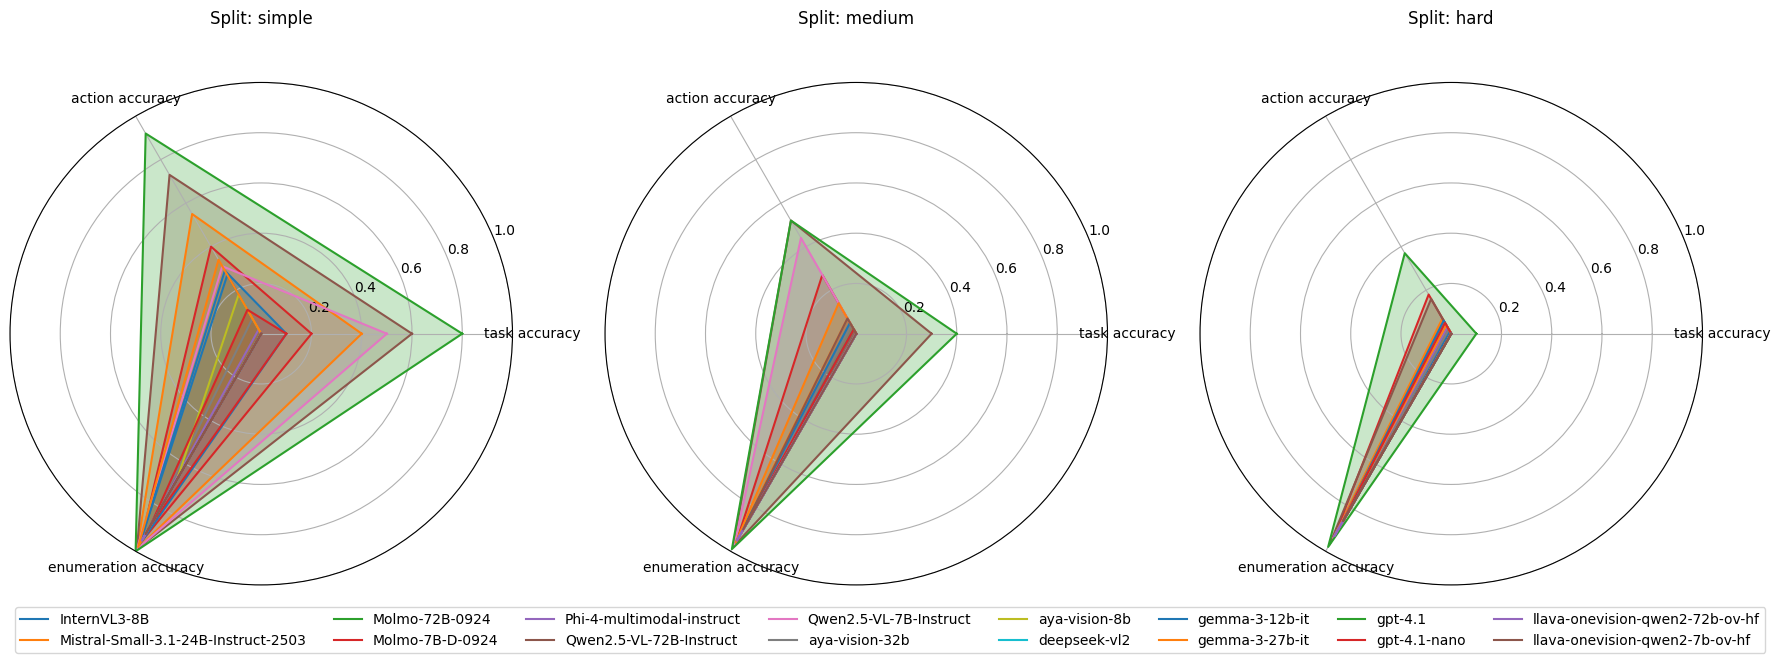

In [9]:
def plot_radar_main_table(main_table, metrics=['task accuracy', 'action accuracy', 'enumeration accuracy']):
    fig, axes = plt.subplots(1, len(splits), figsize=(18, 6),
                            subplot_kw={'polar': True})

    for ax, split in zip(axes, splits):
        df_split = main_table[main_table['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue

        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # close the circle

        for _, row in df_split.iterrows():
            values = [row[m] for m in metrics]
            values += values[:1]
            ax.plot(angles, values, label=row['model'])
            ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1)
        ax.set_title(f'Split: {split}', y=1.1)

    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            break

    ncol = int(np.ceil(len(labels) / 2))
    fig.legend(handles, labels, loc='lower center', ncol=ncol, 
            bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
    
plot_radar_main_table(predicates_main_table, metrics=['task accuracy', 'action accuracy', 'enumeration accuracy'])

In [10]:
def compute_enum_per_predicate(results):
    rows = []
    rows_yes_no = []
    for split in splits:
        for model, data in results.get(split, {}).items():
            problem_keys = [k for k in data.keys() if isinstance(data[k], dict) and 'initial_state_enum' in data[k]]
            accuracies = {}
            yes_accuracies = {}
            yes_totals = {}
            no_accuracies = {}
            no_totals = {}
            for problem in problem_keys:
                predicate_enum_stats = data[problem]['initial_state_enum']['statistics']['predicates']
                for predicate, stats in predicate_enum_stats.items():
                    if predicate not in accuracies:
                        accuracies[predicate] = []
                        yes_accuracies[predicate] = []
                        no_accuracies[predicate] = []
                        yes_totals[predicate] = 0
                        no_totals[predicate] = 0
                    accuracies[predicate].append(stats['accuracy'])
                    if stats['yes_accuracy'] is not None:
                        yes_accuracies[predicate].append(stats['yes_accuracy'])
                    else:
                        print(f"Missing yes_accuracy for {predicate} in {problem} with model {model} (likely no questions had yes answers)")
                    if stats['no_accuracy'] is not None:
                        no_accuracies[predicate].append(stats['no_accuracy'])
                    else:
                        print(f"Missing no_accuracy for {predicate} in {problem} with model {model} (likely no questions had no answers)")
                    
                    yes_totals[predicate] += stats['yes_total']
                    no_totals[predicate] += stats['no_total']
                    
            predicate_accuracies = {predicate: np.round(np.mean(acc), 2) for predicate, acc in accuracies.items()}
            yes_accuracies = {predicate: np.round(np.mean(acc), 2) for predicate, acc in yes_accuracies.items()}
            no_accuracies = {predicate: np.round(np.mean(acc), 2) for predicate, acc in no_accuracies.items()}
            rows.append({
                'model': model,
                'split': split,
                **predicate_accuracies# call it

            })
            
            row_yes_no = {
                'model': model,
                'split': split,
            }
            for predicate, acc in yes_accuracies.items():
                row_yes_no[f'{predicate} (yes)'] = acc
            for predicate, total in yes_totals.items():
                row_yes_no[f'{predicate} (yes total)'] = total
            for predicate, acc in no_accuracies.items():
                row_yes_no[f'{predicate} (no)'] = acc
            for predicate, total in no_totals.items():
                row_yes_no[f'{predicate} (no total)'] = total
            rows_yes_no.append(row_yes_no)
            
            
    df = pd.DataFrame(rows)
    df['split'] = pd.Categorical(df['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df = df.sort_values(by=['model', 'split'])
    
    df_yes_no = pd.DataFrame(rows_yes_no)
    df_yes_no['split'] = pd.Categorical(df_yes_no['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df_yes_no = df_yes_no.sort_values(by=['model', 'split'])
    
    return df, df_yes_no

predicates_enum_table, predicates_enum_yes_no_table = compute_enum_per_predicate(predicates_results)
predicates_enum_table

Missing yes_accuracy for on in data/planning/blocksworld/problems/simple/simple_problem_5.pddl with model InternVL3-8B (likely no questions had yes answers)
Missing no_accuracy for clear in data/planning/blocksworld/problems/simple/simple_problem_5.pddl with model InternVL3-8B (likely no questions had no answers)
Missing yes_accuracy for on in data/planning/blocksworld/problems/simple/simple_problem_3.pddl with model InternVL3-8B (likely no questions had yes answers)
Missing no_accuracy for clear in data/planning/blocksworld/problems/simple/simple_problem_3.pddl with model InternVL3-8B (likely no questions had no answers)
Missing yes_accuracy for on in data/planning/blocksworld/problems/simple/simple_problem_9.pddl with model InternVL3-8B (likely no questions had yes answers)
Missing no_accuracy for clear in data/planning/blocksworld/problems/simple/simple_problem_9.pddl with model InternVL3-8B (likely no questions had no answers)
Missing yes_accuracy for on in data/planning/blocksworl

model   split    on  incolumn  clear  \
0                          InternVL3-8B  simple  0.97      0.97   0.63   
16                         InternVL3-8B  medium  0.95      0.96   0.74   
32                         InternVL3-8B    hard  0.90      0.98   0.57   
13  Mistral-Small-3.1-24B-Instruct-2503  simple  1.00      0.98   0.90   
29  Mistral-Small-3.1-24B-Instruct-2503  medium  0.96      0.96   0.76   
45  Mistral-Small-3.1-24B-Instruct-2503    hard  0.93      0.97   0.75   
14                       Molmo-72B-0924  simple   NaN       NaN    NaN   
30                       Molmo-72B-0924  medium   NaN       NaN    NaN   
46                       Molmo-72B-0924    hard   NaN       NaN    NaN   
12                      Molmo-7B-D-0924  simple  0.92      0.97   0.83   
28                      Molmo-7B-D-0924  medium  0.90      0.98   0.84   
44                      Molmo-7B-D-0924    hard  0.90      0.95   0.87   
8             Phi-4-multimodal-instruct  simple  0.84      0.94   0.53   
24            Phi-4-multimodal-instruct  medium  0.80      0.95   0.54   
40            Phi-4-multimodal-instruct    hard  0.64      0.97   0.43   
5               Qwen2.5-VL-72B-Instruct  simple  0.99      0.98   1.00   
21              Qwen2.5-VL-72B-Instruct  medium  0.97      0.97   0.92   
37              Qwen2.5-VL-72B-Instruct    hard  0.94      0.96   0.95   
9                Qwen2.5-VL-7B-Instruct  simple  1.00      1.00   0.93   
25               Qwen2.5-VL-7B-Instruct  medium  0.97      0.97   0.86   
41               Qwen2.5-VL-7B-Instruct    hard  0.96      0.97   0.75   
7                        aya-vision-32b  simple  0.74      0.79   0.73   
23                       aya-vision-32b  medium  0.68      0.82   0.80   
39                       aya-vision-32b    hard  0.52      0.85   0.53   
11                        aya-vision-8b  simple  0.88      0.71   0.77   
27                        aya-vision-8b  medium  0.90      0.75   0.66   
43                        aya-vision-8b    hard  0.92      0.82   0.50   
10                         deepseek-vl2  simple  0.92      0.96   0.33   
26                         deepseek-vl2  medium  0.87      0.94   0.32   
42                         deepseek-vl2    hard  0.81      0.95   0.48   
2                        gemma-3-12b-it  simple  0.97      0.96   0.67   
18                       gemma-3-12b-it  medium  0.93      0.96   0.72   
34                       gemma-3-12b-it    hard  0.82      0.92   0.63   
3                        gemma-3-27b-it  simple  0.98      0.98   0.80   
19                       gemma-3-27b-it  medium  0.96      0.99   0.68   
35                       gemma-3-27b-it    hard  0.90      0.96   0.73   
1                               gpt-4.1  simple  1.00      0.98   1.00   
17                              gpt-4.1  medium  0.98      1.00   0.98   
33                              gpt-4.1    hard  0.97      0.98   0.97   
6                          gpt-4.1-nano  simple  0.94      0.99   0.73   
22                         gpt-4.1-nano  medium  0.87      0.94   0.68   
38                         gpt-4.1-nano    hard  0.82      0.93   0.63   
15      llava-onevision-qwen2-72b-ov-hf  simple  0.97      0.92   0.53   
31      llava-onevision-qwen2-72b-ov-hf  medium  0.96      0.93   0.52   
47      llava-onevision-qwen2-72b-ov-hf    hard  0.91      0.92   0.60   
4        llava-onevision-qwen2-7b-ov-hf  simple  0.92      0.86   0.53   
20       llava-onevision-qwen2-7b-ov-hf  medium  0.86      0.90   0.42   
36       llava-onevision-qwen2-7b-ov-hf    hard  0.80      0.92   0.45   

    rightof  leftof  
0      1.00    1.00  
16     1.00    1.00  
32     0.99    1.00  
13     1.00    1.00  
29     0.98    0.99  
45     0.99    1.00  
14      NaN     NaN  
30      NaN     NaN  
46      NaN     NaN  
12     1.00    0.96  
28     0.98    0.96  
44     0.96    0.96  
8      1.00    1.00  
24     1.00    1.00  
40     1.00    1.00  
5      1.00    1.00  
21     1.00    1.00  
37     1.00

In [11]:
predicates_enum_yes_no_table

model   split  on (yes)  incolumn (yes)  \
0                          InternVL3-8B  simple      1.00            1.00   
16                         InternVL3-8B  medium      0.83            0.98   
32                         InternVL3-8B    hard      0.94            0.98   
13  Mistral-Small-3.1-24B-Instruct-2503  simple      1.00            1.00   
29  Mistral-Small-3.1-24B-Instruct-2503  medium      0.81            0.96   
45  Mistral-Small-3.1-24B-Instruct-2503    hard      0.70            0.95   
14                       Molmo-72B-0924  simple       NaN             NaN   
30                       Molmo-72B-0924  medium       NaN             NaN   
46                       Molmo-72B-0924    hard       NaN             NaN   
12                      Molmo-7B-D-0924  simple      1.00            0.93   
28                      Molmo-7B-D-0924  medium      0.96            0.94   
44                      Molmo-7B-D-0924    hard      0.86            0.87   
8             Phi-4-multimodal-instruct  simple      1.00            0.97   
24            Phi-4-multimodal-instruct  medium      0.96            0.96   
40            Phi-4-multimodal-instruct    hard      1.00            1.00   
5               Qwen2.5-VL-72B-Instruct  simple      1.00            1.00   
21              Qwen2.5-VL-72B-Instruct  medium      0.88            0.90   
37              Qwen2.5-VL-72B-Instruct    hard      0.72            0.92   
9                Qwen2.5-VL-7B-Instruct  simple      1.00            1.00   
25               Qwen2.5-VL-7B-Instruct  medium      0.88            0.88   
41               Qwen2.5-VL-7B-Instruct    hard      0.85            0.87   
7                        aya-vision-32b  simple      1.00            0.97   
23                       aya-vision-32b  medium      1.00            0.84   
39                       aya-vision-32b    hard      0.97            1.00   
11                        aya-vision-8b  simple      0.86            0.93   
27                        aya-vision-8b  medium      0.73            0.92   
43                        aya-vision-8b    hard      0.45            0.97   
10                         deepseek-vl2  simple      1.00            0.97   
26                         deepseek-vl2  medium      1.00            0.98   
42                         deepseek-vl2    hard      0.95            0.97   
2                        gemma-3-12b-it  simple      1.00            1.00   
18                       gemma-3-12b-it  medium      0.79            0.98   
34                       gemma-3-12b-it    hard      0.74            0.93   
3                        gemma-3-27b-it  simple      1.00            1.00   
19                       gemma-3-27b-it  medium      0.85            0.98   
35                       gemma-3-27b-it    hard      0.73            0.95   
1                               gpt-4.1  simple      1.00            0.97   
17                              gpt-4.1  medium      0.92            1.00   
33                              gpt-4.1    hard      0.98            0.98   
6                          gpt-4.1-nano  simple      0.86            0.97   
22                         gpt-4.1-nano  medium      0.81            0.98   
38                         gpt-4.1-nano    hard      0.80            0.92   
15      llava-onevision-qwen2-72b-ov-hf  simple      1.00            0.97   
31      llava-onevision-qwen2-72b-ov-hf  medium      0.96            0.98   
47      llava-onevision-qwen2-72b-ov-hf    hard      0.79            0.92   
4        llava-onevision-qwen2-7b-ov-hf  simple      1.00            0.93   
20       llava-onevision-qwen2-7b-ov-hf  medium      0.88            0.96   
36       llava-onevision-qwen2-7b-ov-hf    hard      0.83            0.88   

    clear (yes)  rightof (yes)  leftof (yes)  on (yes total)  \
0          0.80           1.00          1.00             7.0   
16         0.97           1.00          1.00            16.0   
32         0.85           1.00          1.00            22.0   
13  

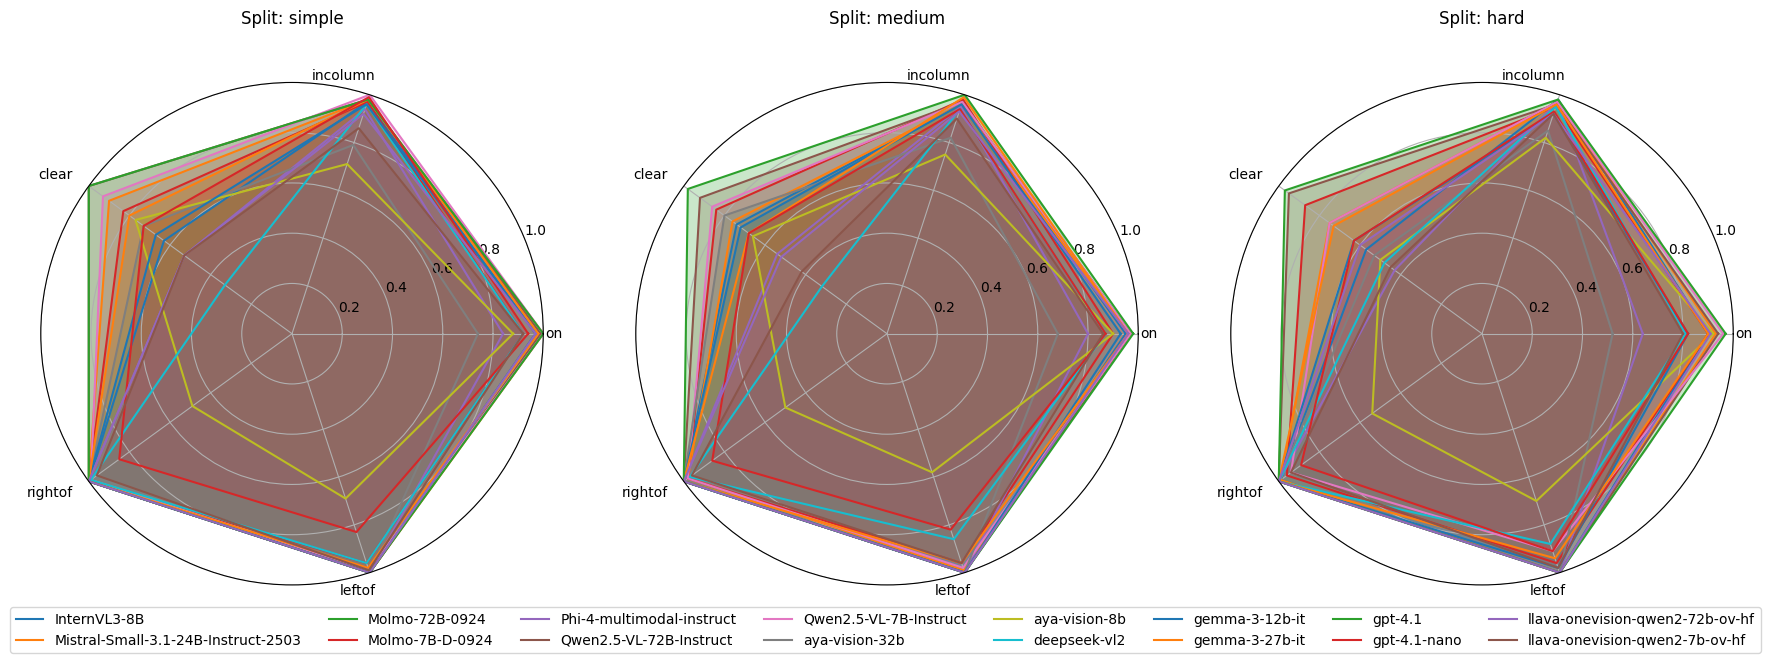

In [12]:
def plot_radar_enum_table(enum_table):
    """
    Create a radar plot for predicate enumeration accuracies per split.
    """
    metrics = [c for c in enum_table.columns if c not in ['model', 'split']]
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    fig, axes = plt.subplots(1, len(splits), figsize=(18, 6), subplot_kw={'polar': True})

    for ax, split in zip(axes, splits):
        df_split = enum_table[enum_table['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue

        for _, row in df_split.iterrows():
            values = [row[m] for m in metrics]
            values += values[:1]
            ax.plot(angles, values, label=row['model'])
            ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.set_title(f'Split: {split}', y=1.1)

    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            break

    ncol = int(np.ceil(len(labels) / 2))
    fig.legend(handles, labels, loc='lower center', ncol=ncol, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

plot_radar_enum_table(predicates_enum_table)

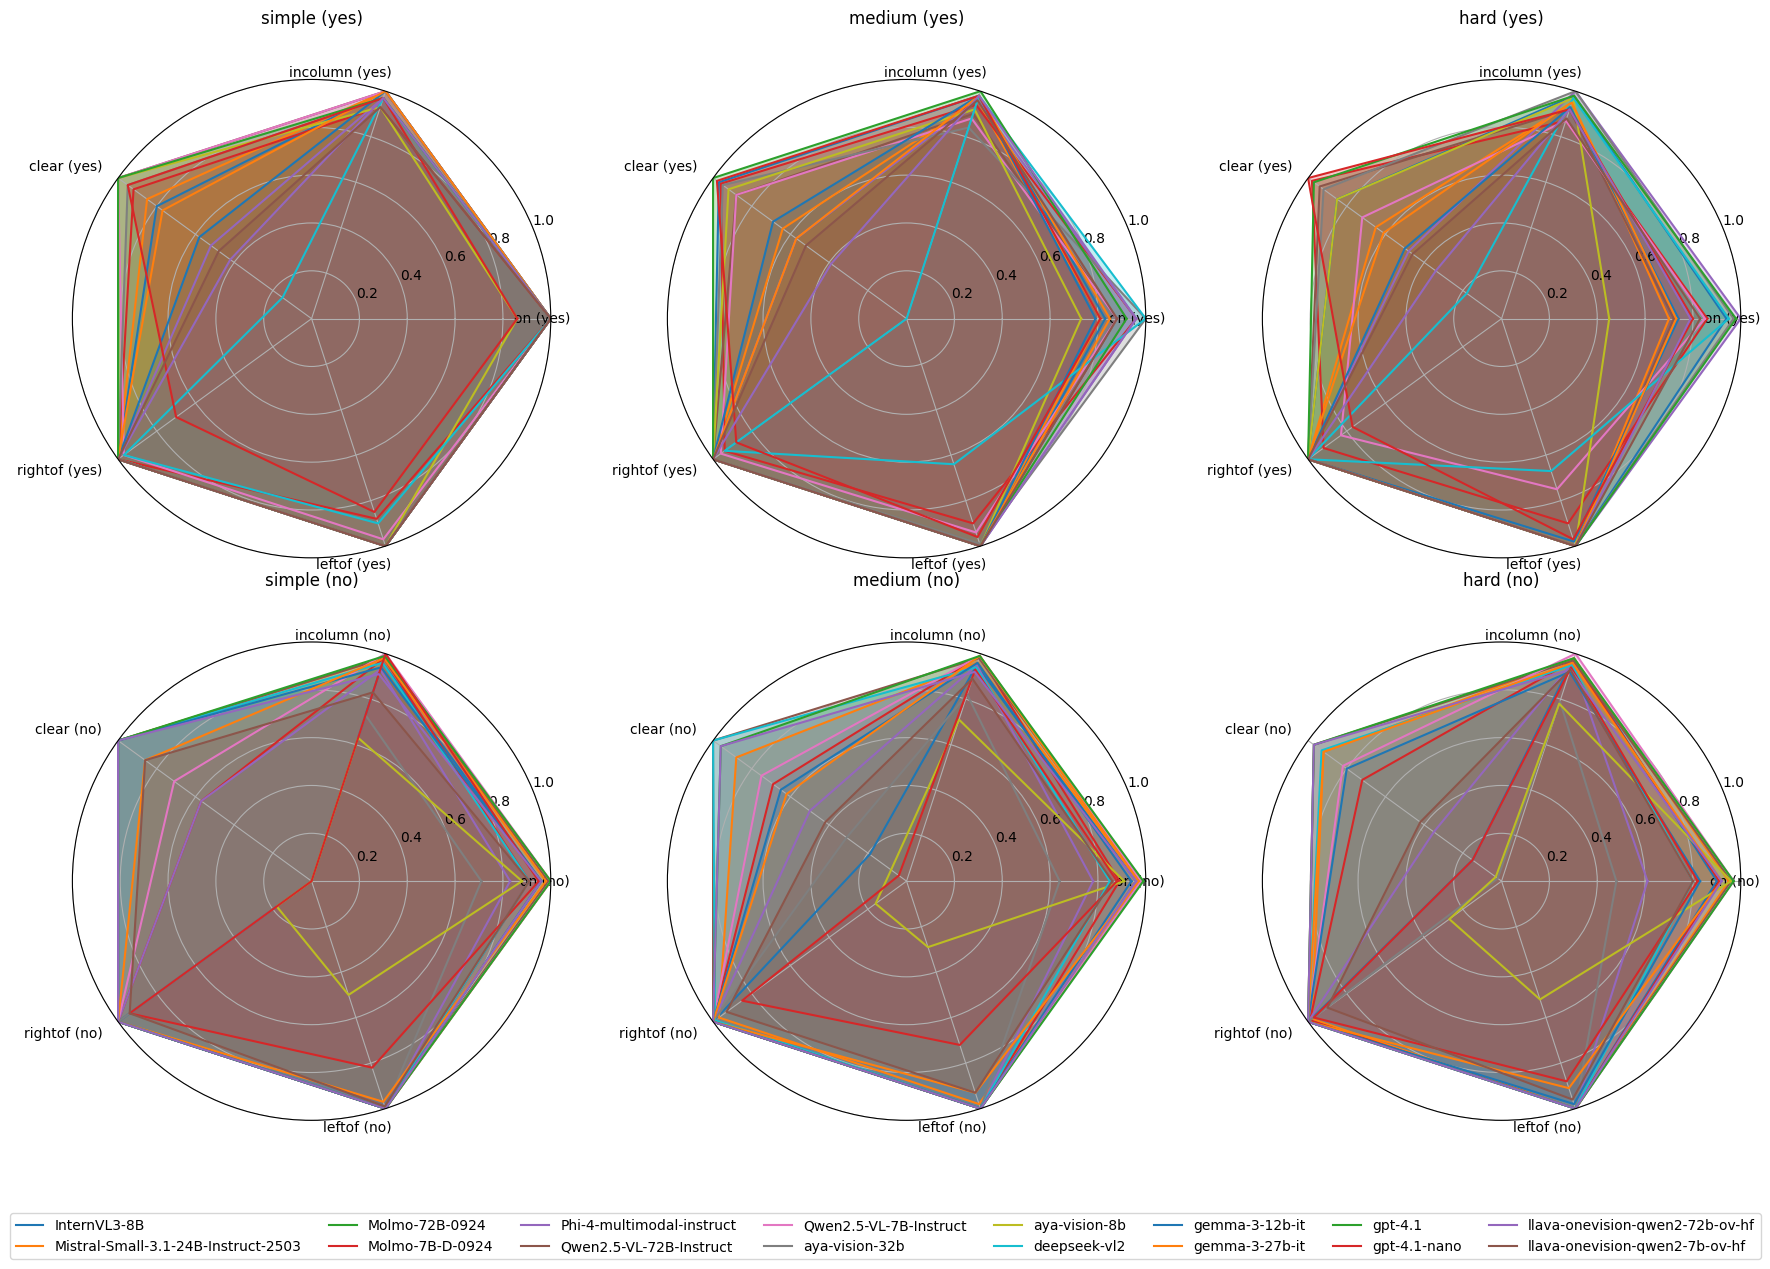

In [13]:
# Columns for yes/no accuracies
yesno_cols = ['on (yes)', 'incolumn (yes)', 'clear (yes)', 'rightof (yes)', 'leftof (yes)',
              'on (no)',  'incolumn (no)',  'clear (no)',  'rightof (no)',  'leftof (no)']
yes_cols = [c for c in yesno_cols if '(yes)' in c]
no_cols  = [c for c in yesno_cols if '(no)' in c]

# Create a 2×3 grid of radar plots: first row = yes, second = no
fig, axes = plt.subplots(2, len(splits), figsize=(18, 12), subplot_kw={'polar': True})

for i, (lbl, cols) in enumerate([('yes', yes_cols), ('no', no_cols)]):
    for j, split in enumerate(splits):
        ax = axes[i][j]
        df_split = predicates_enum_yes_no_table[predicates_enum_yes_no_table['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue

        angles = np.linspace(0, 2 * np.pi, len(cols), endpoint=False).tolist()
        angles += angles[:1]

        for _, row in df_split.iterrows():
            vals = [row[c] for c in cols] + [row[cols[0]]]
            ax.plot(angles, vals, label=row['model'])
            ax.fill(angles, vals, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(cols, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.set_title(f"{split} ({lbl})", y=1.1)

# Common legend
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=int(np.ceil(len(labels)/2)), bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [14]:
# Compute precision and recall for "yes" and "no" answers
yes_acc_cols = yes_cols
yes_tot_cols = [col.replace('(yes)', '(yes total)') for col in yes_acc_cols]
no_acc_cols  = no_cols
no_tot_cols  = [col.replace('(no)', '(no total)')  for col in no_acc_cols]

# slice the DataFrame
yes_acc_df = predicates_enum_yes_no_table[yes_acc_cols]
yes_tot_df = predicates_enum_yes_no_table[yes_tot_cols]
no_acc_df  = predicates_enum_yes_no_table[no_acc_cols]
no_tot_df  = predicates_enum_yes_no_table[no_tot_cols]

# true positives, false negatives, false positives for "yes"
tp_yes     = (yes_acc_df.values * yes_tot_df.values).sum(axis=1)
total_yes  = yes_tot_df.sum(axis=1)
fn_yes     = total_yes - tp_yes
correct_no = (no_acc_df.values  * no_tot_df.values).sum(axis=1)
total_no   = no_tot_df.sum(axis=1)
fp_yes     = total_no - correct_no

# true positives, false negatives, false positives for "no"
tp_no   = correct_no
fn_no   = total_no - tp_no
fp_no   = total_yes - tp_yes

# assemble metrics
metrics_df = predicates_enum_yes_no_table[['model','split']].copy()
metrics_df['precision_yes'] = tp_yes / (tp_yes + fp_yes)
metrics_df['recall_yes']    = tp_yes / (tp_yes + fn_yes)
metrics_df['precision_no']  = tp_no  / (tp_no  + fp_no)
metrics_df['recall_no']     = tp_no  / (tp_no  + fn_no)

metrics_df

model   split  precision_yes  recall_yes  \
0                          InternVL3-8B  simple       0.926474    0.974444   
16                         InternVL3-8B  medium       0.901337    0.984200   
32                         InternVL3-8B    hard       0.797434    0.966667   
13  Mistral-Small-3.1-24B-Instruct-2503  simple       0.989907    0.980833   
29  Mistral-Small-3.1-24B-Instruct-2503  medium       0.920432    0.942400   
45  Mistral-Small-3.1-24B-Instruct-2503    hard       0.899123    0.905417   
14                       Molmo-72B-0924  simple            NaN         NaN   
30                       Molmo-72B-0924  medium            NaN         NaN   
46                       Molmo-72B-0924    hard            NaN         NaN   
12                      Molmo-7B-D-0924  simple       0.932207    0.938111   
28                      Molmo-7B-D-0924  medium       0.895091    0.930000   
44                      Molmo-7B-D-0924    hard       0.832298    0.904500   
8             Phi-4-multimodal-instruct  simple       0.877690    0.933667   
24            Phi-4-multimodal-instruct  medium       0.802737    0.942467   
40            Phi-4-multimodal-instruct    hard       0.590209    0.926333   
5               Qwen2.5-VL-72B-Instruct  simple       0.985599    1.000000   
21              Qwen2.5-VL-72B-Instruct  medium       0.970841    0.963333   
37              Qwen2.5-VL-72B-Instruct    hard       0.920381    0.941167   
9                Qwen2.5-VL-7B-Instruct  simple       0.988623    0.980000   
25               Qwen2.5-VL-7B-Instruct  medium       0.963004    0.926667   
41               Qwen2.5-VL-7B-Instruct    hard       0.929422    0.806583   
7                        aya-vision-32b  simple       0.762686    0.988611   
23                       aya-vision-32b  medium       0.687860    0.964333   
39                       aya-vision-32b    hard       0.499514    0.985417   
11                        aya-vision-8b  simple       0.492566    0.982889   
27                        aya-vision-8b  medium       0.469670    0.963200   
43                        aya-vision-8b    hard       0.523470    0.911667   
10                         deepseek-vl2  simple       0.932011    0.843056   
26                         deepseek-vl2  medium       0.821060    0.743333   
42                         deepseek-vl2    hard       0.709114    0.788417   
2                        gemma-3-12b-it  simple       0.951301    0.946333   
18                       gemma-3-12b-it  medium       0.911620    0.950333   
34                       gemma-3-12b-it    hard       0.728995    0.878500   
3                        gemma-3-27b-it  simple       0.959155    0.970611   
19                       gemma-3-27b-it  medium       0.916770    0.939933   
35                       gemma-3-27b-it    hard       0.828061    0.903000   
1                               gpt-4.1  simple       0.995000    0.995000   
17                              gpt-4.1  medium       0.983602    0.995733   
33                              gpt-4.1    hard       0.942780    0.988583   
6                          gpt-4.1-nano  simple       0.810123    0.833167   
22                         gpt-4.1-nano  medium       0.696077    0.930933   
38                         gpt-4.1-nano    hard       0.664971    0.893333   
15      llava-onevision-qwen2-72b-ov-hf  simple       0.935546    0.920889   
31      llava-onevision-qwen2-72b-ov-hf  medium       0.914367    0.925400   
47      llava-onevision-qwen2-72b-ov-hf    hard       0.837914    0.863750   
4        llava-onevision-qwen2-7b-ov-hf  simple       0.843663    0.921889   
20       llava-onevision-qwen2-7b-ov-hf  medium       0.766886    0.932533   
36       llava-onevision-qwen2-7b-ov-hf    hard       0.659403    0.875083   

    precision_no  recall_no  
0       0.987590   0.963368  
16      0.993439   0.956907  
32      0.988390   0.920360  
13      0.990960   0.995263  
29      0.976738   0.967413  
45      0.969255   0.967054  
1

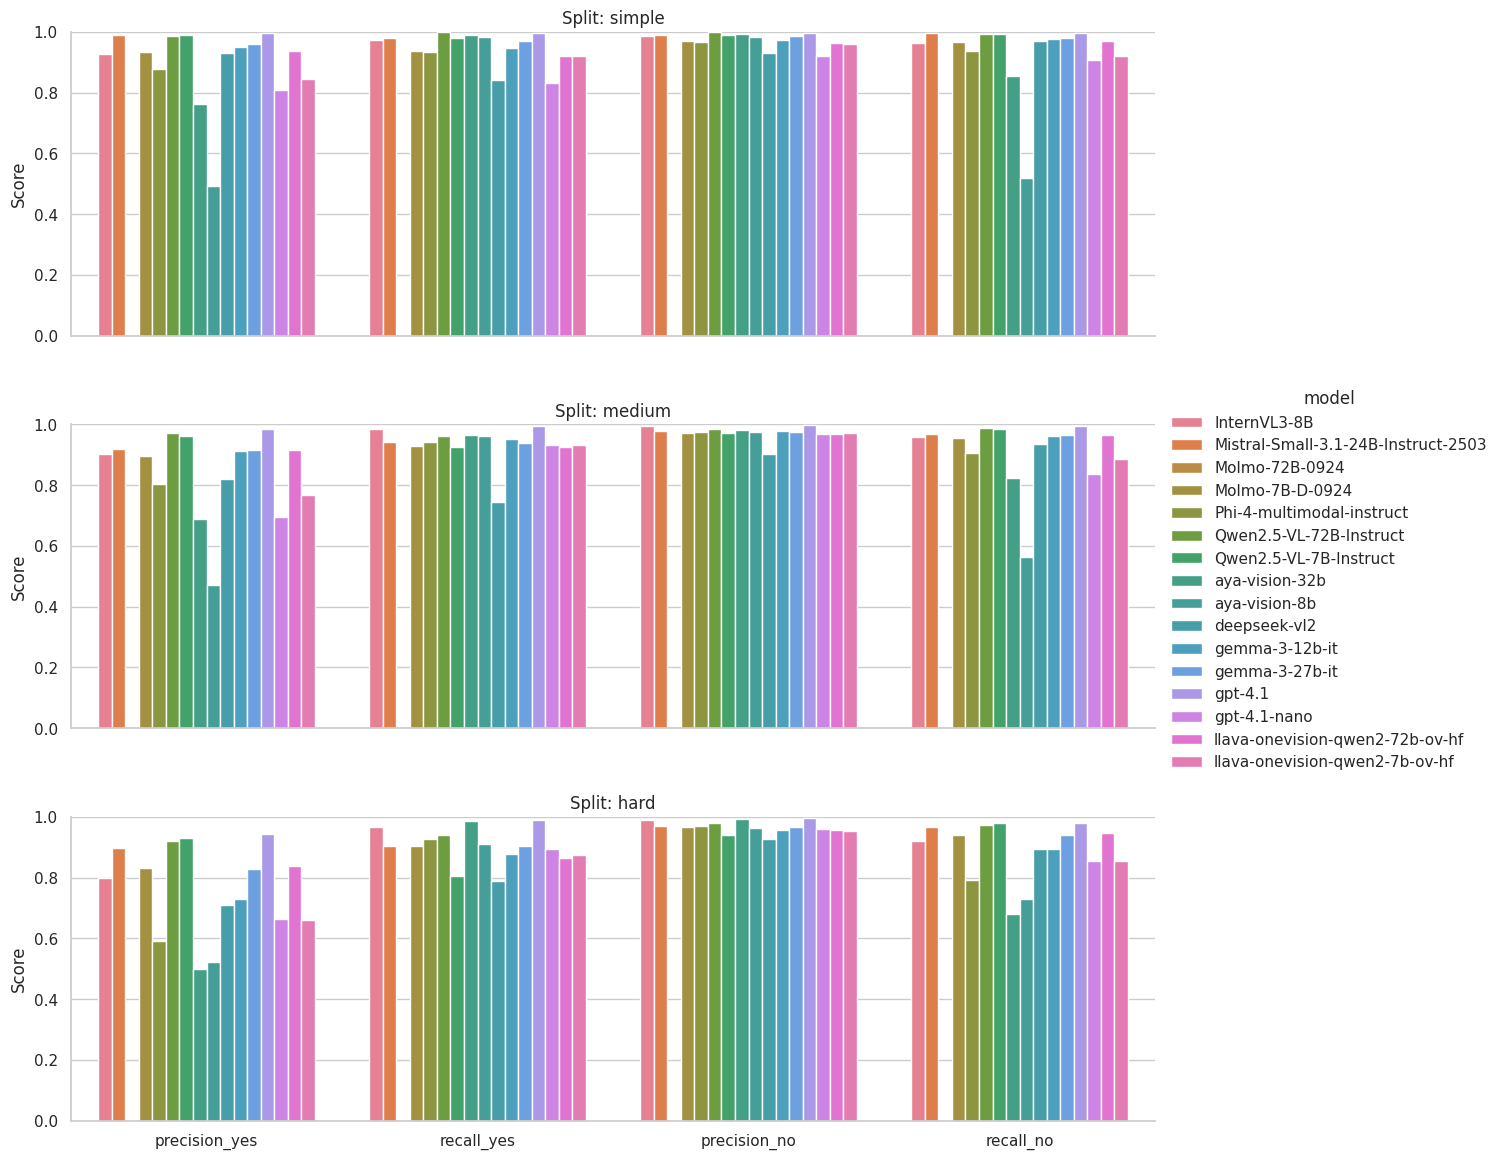

In [15]:
import seaborn as sns

# Melt the metrics dataframe to long format
metrics_long = metrics_df.melt(
    id_vars=['model', 'split'],
    value_vars=['precision_yes', 'recall_yes', 'precision_no', 'recall_no'],
    var_name='metric',
    value_name='score'
)

# Plot a grouped bar chart of precision/recall by split in a 3×1 layout
sns.set(style="whitegrid")
g = sns.catplot(
    data=metrics_long,
    x='metric',
    y='score',
    hue='model',
    row='split',
    kind='bar',
    height=4,
    aspect=3   # make each plot wider
)
g.set_axis_labels("", "Score")
g.set_titles("Split: {row_name}")
g.set(ylim=(0, 1))
# plt.tight_layout()
plt.show()

In [16]:
def compute_action_predicates_accuracies(results):

    stats = {}
    for split in splits:
        stats[split] = {}
        for model, data in results.get(split, {}).items():
            stats[split][model] = {}
            problem_keys = [k for k in data.keys() if isinstance(data[k], dict) and 'action_results' in data[k]]
            for problem in problem_keys:
                action_results = data[problem]['action_results']
                if action_results is None:
                    print(f"Missing action results for {problem} with model {model}")
                    continue
                for action in action_results:
                    precondition_results = action['preconditions_results']
                    effect_results = action['effects_results']
                    
                    for predicate, result in precondition_results.items():
                        if predicate == 'all_correct':
                            continue
                        predicate = predicate.split(" ")[0]
                        if predicate not in stats[split][model]:
                            stats[split][model][predicate] = {'preconditions': {'yes_total': 0, 'no_total': 0, 'yes_correct': 0, 'no_correct': 0},
                                                              'effects': {'yes_total': 0, 'no_total': 0, 'yes_correct': 0, 'no_correct': 0}}
                        vlm_answer, yes_prob, no_prob, _, answer_correct, _ = result
                        if vlm_answer.lower() == 'yes':
                            if answer_correct:
                                stats[split][model][predicate]['preconditions']['yes_correct'] += 1
                                stats[split][model][predicate]['preconditions']['yes_total'] += 1
                            else:
                                stats[split][model][predicate]['preconditions']['no_total'] += 1
                        elif vlm_answer.lower() == 'no':
                            if answer_correct:
                                stats[split][model][predicate]['preconditions']['no_correct'] += 1
                                stats[split][model][predicate]['preconditions']['no_total'] += 1
                            else:
                                stats[split][model][predicate]['preconditions']['yes_total'] += 1
                    
                    if effect_results is None:
                        continue
                                    
                    for predicate, result in effect_results.items():
                        if predicate == 'all_correct':
                            continue
                        predicate = predicate.split(" ")[0]
                        if predicate not in stats[split][model]:
                            stats[split][model][predicate] = {'preconditions': {'yes_total': 0, 'no_total': 0, 'yes_correct': 0, 'no_correct': 0},
                                                              'effects': {'yes_total': 0, 'no_total': 0, 'yes_correct': 0, 'no_correct': 0}}
                        vlm_answer, yes_prob, no_prob, _, answer_correct, _ = result
                        if vlm_answer.lower() == 'yes':
                            if answer_correct:
                                stats[split][model][predicate]['effects']['yes_correct'] += 1
                                stats[split][model][predicate]['effects']['yes_total'] += 1
                            else:
                                stats[split][model][predicate]['effects']['no_total'] += 1
                        elif vlm_answer.lower() == 'no':
                            if answer_correct:
                                stats[split][model][predicate]['effects']['no_correct'] += 1
                                stats[split][model][predicate]['effects']['no_total'] += 1
                            else:
                                stats[split][model][predicate]['effects']['yes_total'] += 1
    for split in stats:
        for model in stats[split]:
            for predicate in stats[split][model]:
                preconditions = stats[split][model][predicate]['preconditions']
                effects = stats[split][model][predicate]['effects']
                if preconditions['yes_total'] > 0:
                    preconditions['yes_accuracy'] = preconditions['yes_correct'] / preconditions['yes_total']
                else:
                    preconditions['yes_accuracy'] = None
                if preconditions['no_total'] > 0:
                    preconditions['no_accuracy'] = preconditions['no_correct'] / preconditions['no_total']
                else:
                    preconditions['no_accuracy'] = None
                if effects['yes_total'] > 0:
                    effects['yes_accuracy'] = effects['yes_correct'] / effects['yes_total']
                else:
                    effects['yes_accuracy'] = None
                if effects['no_total'] > 0:
                    effects['no_accuracy'] = effects['no_correct'] / effects['no_total']
                else:
                    effects['no_accuracy'] = None
                    
                stats[split][model][predicate]['overall'] = {
                    'yes_total': preconditions['yes_total'] + effects['yes_total'],
                    'no_total': preconditions['no_total'] + effects['no_total'],
                    'yes_correct': preconditions['yes_correct'] + effects['yes_correct'],
                    'no_correct': preconditions['no_correct'] + effects['no_correct'],
                }
                if stats[split][model][predicate]['overall']['yes_total'] > 0:
                    stats[split][model][predicate]['overall']['yes_accuracy'] = stats[split][model][predicate]['overall']['yes_correct'] / stats[split][model][predicate]['overall']['yes_total']
                else:
                    stats[split][model][predicate]['overall']['yes_accuracy'] = None
                if stats[split][model][predicate]['overall']['no_total'] > 0:
                    stats[split][model][predicate]['overall']['no_accuracy'] = stats[split][model][predicate]['overall']['no_correct'] / stats[split][model][predicate]['overall']['no_total']
                else:
                    stats[split][model][predicate]['overall']['no_accuracy'] = None
                    
                stats[split][model][predicate]['overall']['total'] = stats[split][model][predicate]['overall']['yes_total'] + stats[split][model][predicate]['overall']['no_total']
                stats[split][model][predicate]['overall']['correct'] = stats[split][model][predicate]['overall']['yes_correct'] + stats[split][model][predicate]['overall']['no_correct']
                stats[split][model][predicate]['overall']['accuracy'] = stats[split][model][predicate]['overall']['correct'] / stats[split][model][predicate]['overall']['total']
                

                                
    return stats
predicates_action_stats = compute_action_predicates_accuracies(predicates_results)
predicates_action_stats

Missing action results for data/planning/blocksworld/problems/simple/simple_problem_8.pddl with model InternVL3-8B
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_1.pddl with model InternVL3-8B
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_4.pddl with model InternVL3-8B
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_6.pddl with model InternVL3-8B
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_8.pddl with model gemma-3-12b-it
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_5.pddl with model gemma-3-12b-it
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_1.pddl with model gemma-3-12b-it
Missing action results for data/planning/blocksworld/problems/simple/simple_problem_4.pddl with model gemma-3-12b-it
Missing action results for data/planning/blocksworld/problems/simple/sim

{'simple': {'InternVL3-8B': {'clear': {'preconditions': {'yes_total': 11,
     'no_total': 0,
     'yes_correct': 11,
     'no_correct': 0,
     'yes_accuracy': 1.0,
     'no_accuracy': None},
    'effects': {'yes_total': 10,
     'no_total': 2,
     'yes_correct': 9,
     'no_correct': 0,
     'yes_accuracy': 0.9,
     'no_accuracy': 0.0},
    'overall': {'yes_total': 21,
     'no_total': 2,
     'yes_correct': 20,
     'no_correct': 0,
     'yes_accuracy': 0.9523809523809523,
     'no_accuracy': 0.0,
     'total': 23,
     'correct': 20,
     'accuracy': 0.8695652173913043}},
   'incolumn': {'preconditions': {'yes_total': 0,
     'no_total': 11,
     'yes_correct': 0,
     'no_correct': 10,
     'yes_accuracy': None,
     'no_accuracy': 0.9090909090909091},
    'effects': {'yes_total': 9,
     'no_total': 9,
     'yes_correct': 8,
     'no_correct': 8,
     'yes_accuracy': 0.8888888888888888,
     'no_accuracy': 0.8888888888888888},
    'overall': {'yes_total': 9,
     'no_total': 20

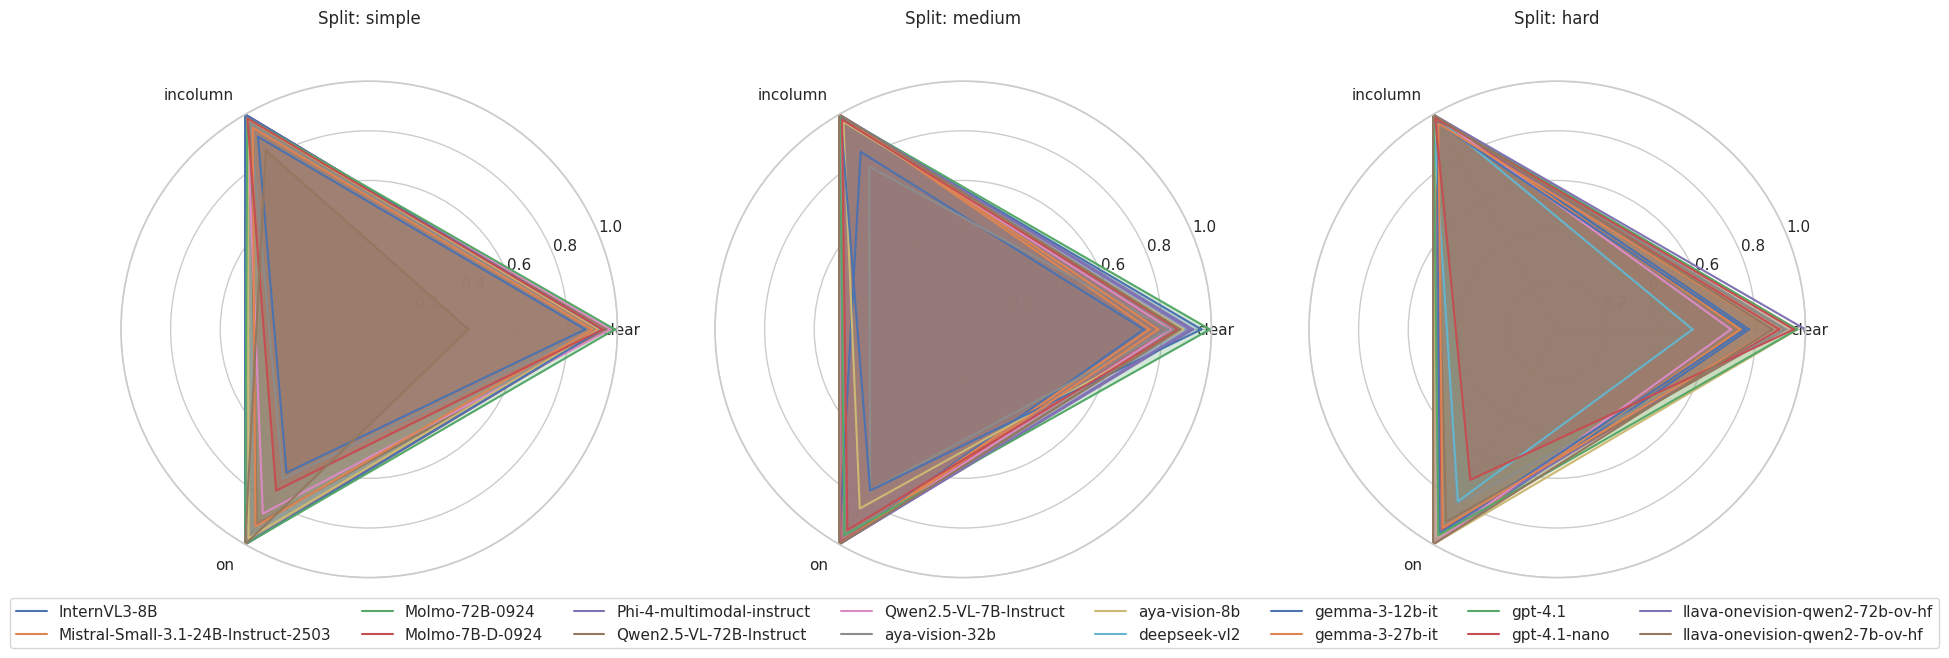

In [17]:
# Prepare a DataFrame of overall action‐predicate accuracies
rows = []
preds = set()
for split, models in predicates_action_stats.items():
    for model, pstats in models.items():
        row = {'model': model, 'split': split}
        for predicate, stats in pstats.items():
            o = stats['overall']
            row[predicate] = o['accuracy']
            preds.add(predicate)
        rows.append(row)

df_action_overall = pd.DataFrame(rows)
df_action_overall['split'] = pd.Categorical(
    df_action_overall['split'],
    categories=['simple','medium','hard'],
    ordered=True
)
df_action_overall = df_action_overall.sort_values(['model','split'])

# Build a consistent color map for models (same as previous radar plots)
models = sorted(df_action_overall['model'].unique())
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {m: default_colors[i % len(default_colors)] for i, m in enumerate(models)}

# Radar plot: 1×3 grid, one subplot per split
predicates = sorted(preds)
angles = np.linspace(0, 2*np.pi, len(predicates), endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(
    1, len(splits), figsize=(18, 6),
    subplot_kw={'polar': True}
)
for ax, split in zip(axes, splits):
    df_split = df_action_overall[df_action_overall['split'] == split]
    if df_split.empty:
        ax.set_visible(False)
        continue

    for _, row in df_split.iterrows():
        vals = [row[p] for p in predicates] + [row[predicates[0]]]
        clr = color_map[row['model']]
        ax.plot(angles, vals, color=clr, label=row['model'])
        ax.fill(angles, vals, color=clr, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(predicates, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.set_title(f'Split: {split}', y=1.1)

# Shared legend at bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=int(np.ceil(len(labels)/2)),
    bbox_to_anchor=(0.5, -0.05)
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

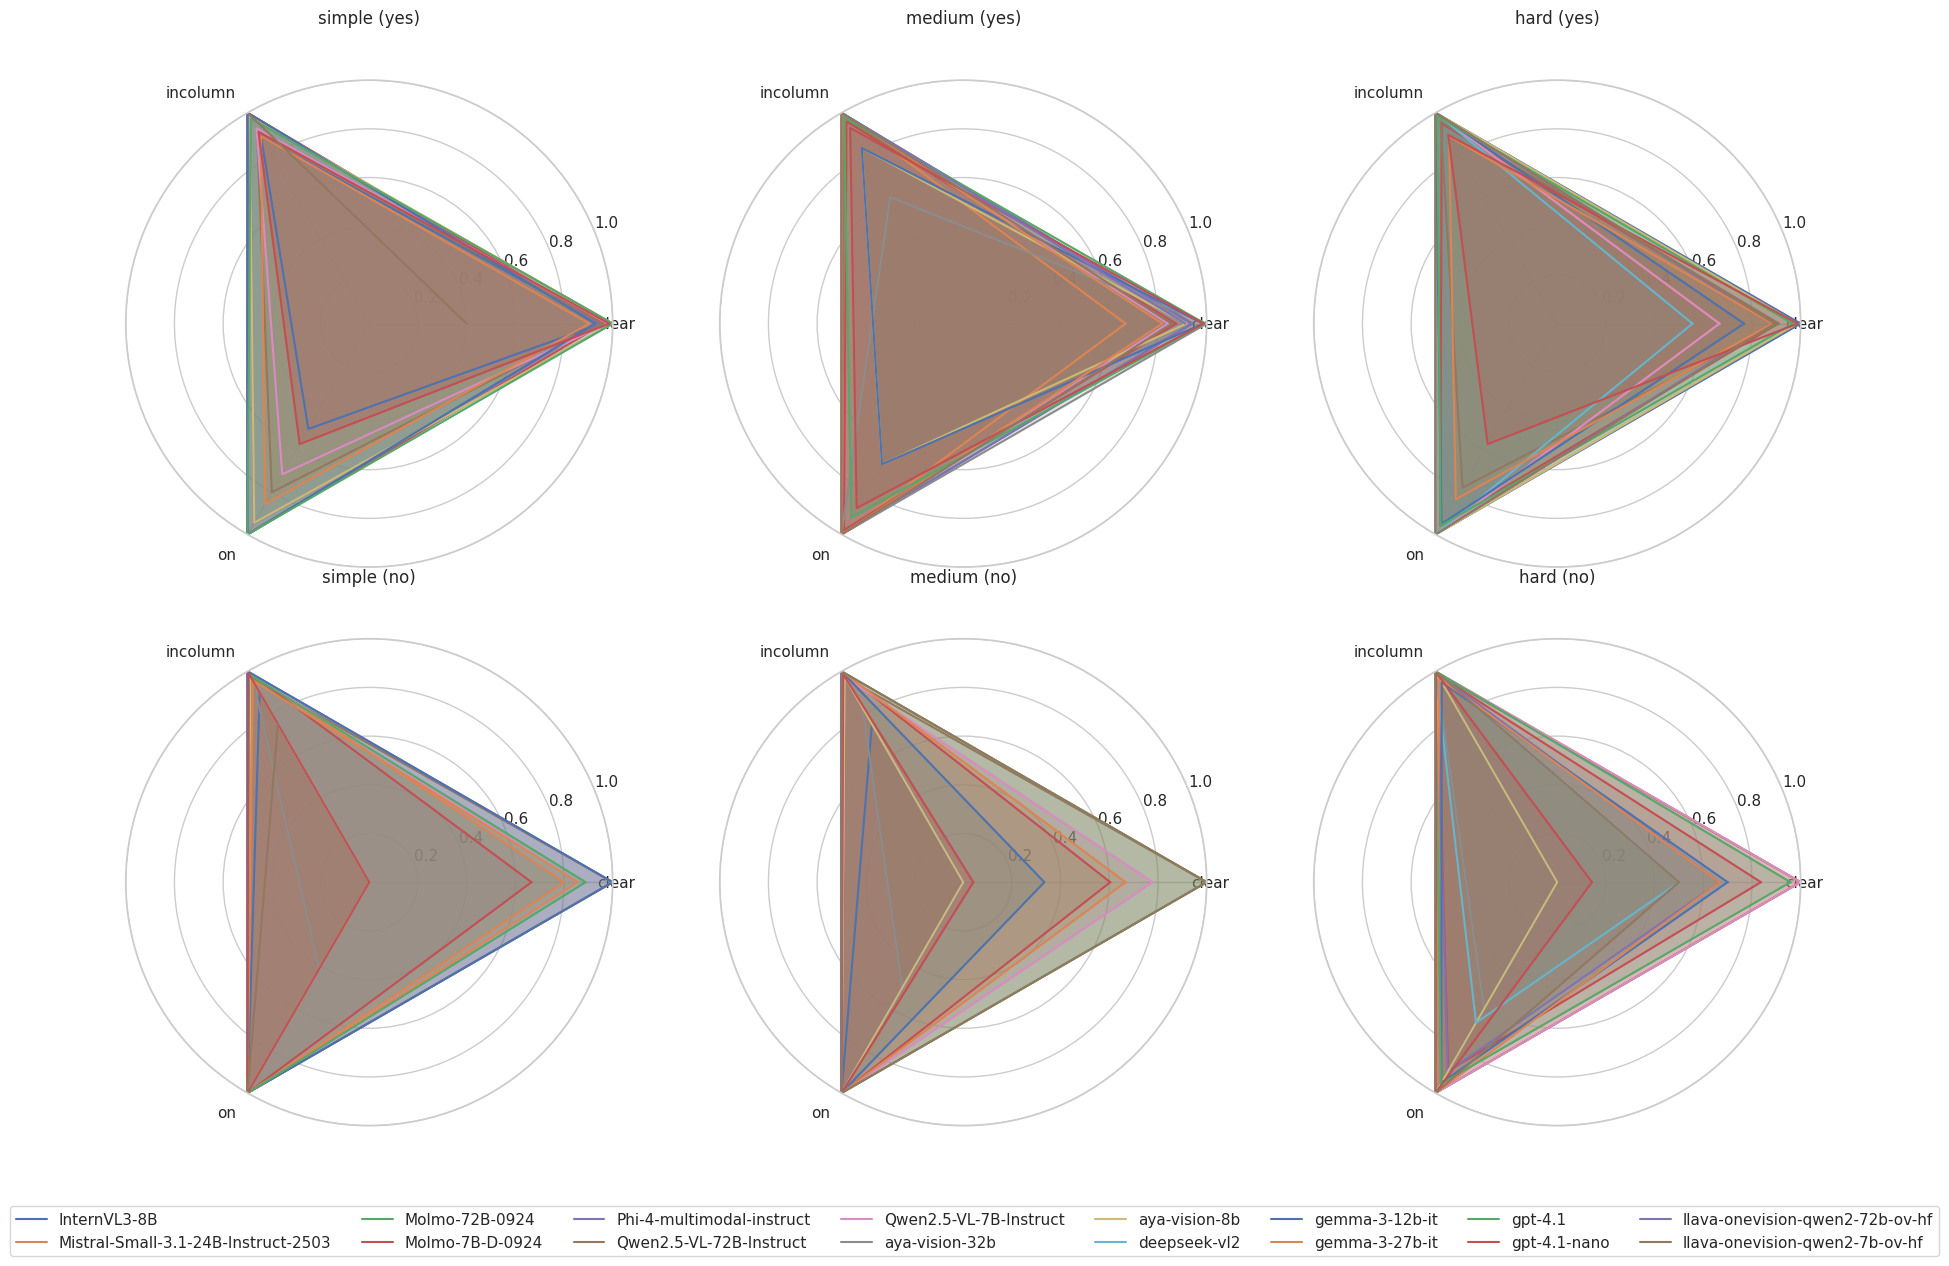

In [18]:
# Prepare DataFrames for action‐predicate yes/no accuracies
preds = sorted({
    p for split_stats in predicates_action_stats.values()
      for model_stats in split_stats.values()
        for p in model_stats.keys()
})
rows_yes, rows_no = [], []
for split, models in predicates_action_stats.items():
    for model, pstats in models.items():
        row_y = {'model': model, 'split': split}
        row_n = {'model': model, 'split': split}
        for p in preds:
            overall = pstats.get(p, {}).get('overall', {})
            row_y[p] = overall.get('yes_accuracy', np.nan)
            row_n[p] = overall.get('no_accuracy', np.nan)
        rows_yes.append(row_y)
        rows_no.append(row_n)

df_yes = pd.DataFrame(rows_yes)
df_no  = pd.DataFrame(rows_no)
for df in (df_yes, df_no):
    df['split'] = pd.Categorical(df['split'],
                                 categories=['simple','medium','hard'],
                                 ordered=True)
    df.sort_values(['model','split'], inplace=True)

# 2×3 radar‐plot grid: first row = yes, second = no
fig, axes = plt.subplots(2, len(splits), figsize=(18, 12),
                         subplot_kw={'polar': True})
for i, (label, df) in enumerate([('yes', df_yes), ('no', df_no)]):
    for j, split in enumerate(splits):
        ax = axes[i][j]
        df_split = df[df['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue
        angles = np.linspace(0, 2*np.pi, len(preds), endpoint=False).tolist()
        angles += angles[:1]
        for _, row in df_split.iterrows():
            vals = [row[p] for p in preds] + [row[preds[0]]]
            clr = color_map[row['model']]
            ax.plot(angles, vals, color=clr, label=row['model'])
            ax.fill(angles, vals, color=clr, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(preds, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.set_title(f"{split} ({label})", y=1.1)

# Shared legend
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=int(np.ceil(len(labels)/2)),
    bbox_to_anchor=(0.5, -0.05)
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

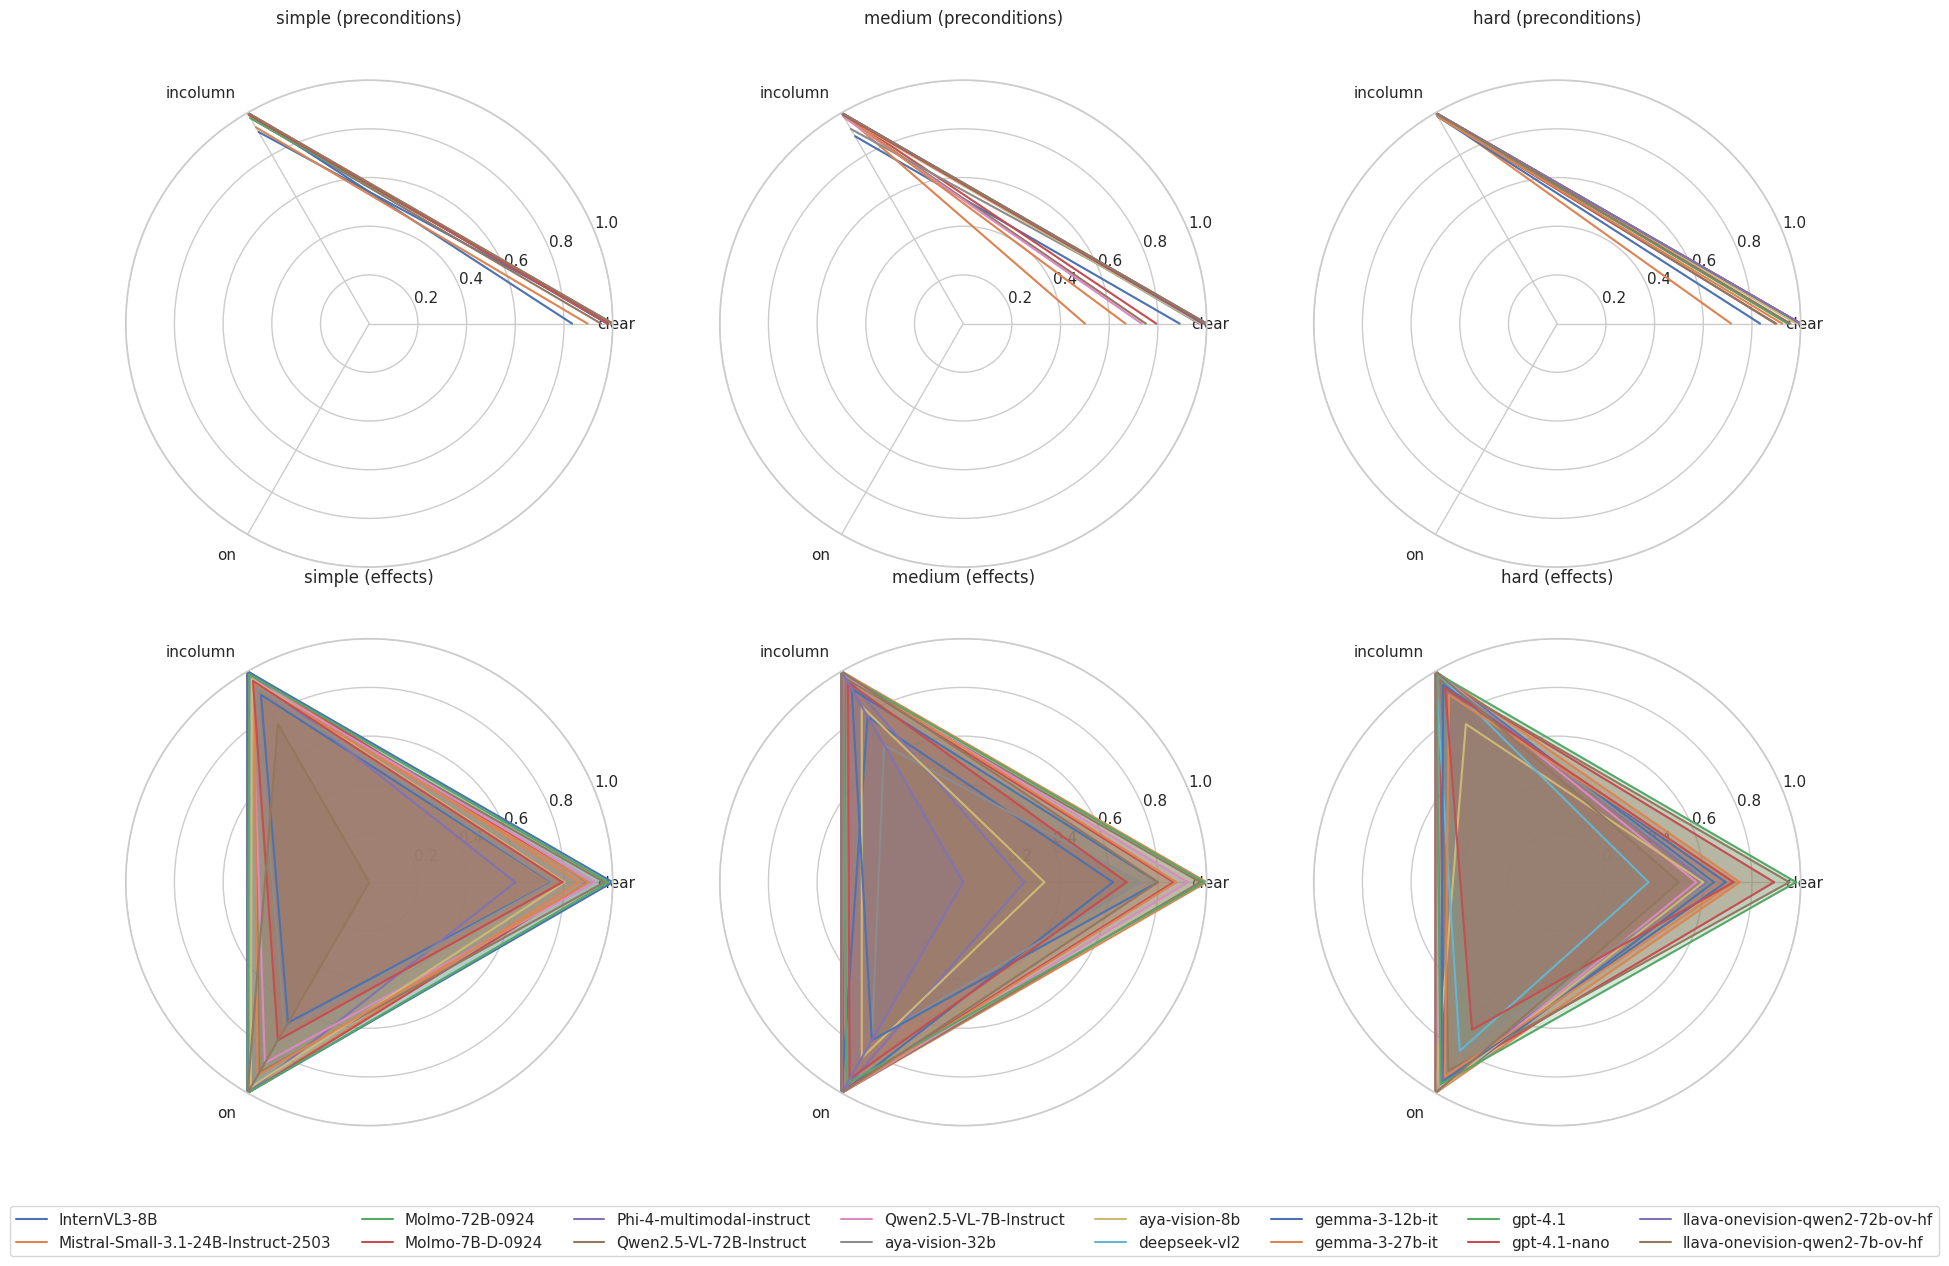

In [19]:
# Prepare DataFrames for preconditions and effects accuracies per predicate
preds = sorted({
    p for split_stats in predicates_action_stats.values()
      for model_stats in split_stats.values()
        for p in model_stats.keys()
})
rows_pre, rows_eff = [], []
for split, models in predicates_action_stats.items():
    for model, pstats in models.items():
        row_pre = {'model': model, 'split': split}
        row_eff = {'model': model, 'split': split}
        for p in preds:
            stats = pstats.get(p, {})
            pre = stats.get('preconditions', {})
            eff = stats.get('effects', {})
            pre_total = pre.get('yes_total', 0) + pre.get('no_total', 0)
            pre_correct = pre.get('yes_correct', 0) + pre.get('no_correct', 0)
            eff_total = eff.get('yes_total', 0) + eff.get('no_total', 0)
            eff_correct = eff.get('yes_correct', 0) + eff.get('no_correct', 0)
            row_pre[p] = pre_correct / pre_total if pre_total else np.nan
            row_eff[p] = eff_correct / eff_total if eff_total else np.nan
        rows_pre.append(row_pre)
        rows_eff.append(row_eff)

df_pre = pd.DataFrame(rows_pre)
df_eff = pd.DataFrame(rows_eff)
for df in (df_pre, df_eff):
    df['split'] = pd.Categorical(df['split'], categories=['simple','medium','hard'], ordered=True)
    df.sort_values(['model','split'], inplace=True)

# 2×3 radar‐plot grid: first row = preconditions, second = effects
fig, axes = plt.subplots(2, len(splits), figsize=(18, 12), subplot_kw={'polar': True})
for i, (label, df) in enumerate([('preconditions', df_pre), ('effects', df_eff)]):
    for j, split in enumerate(splits):
        ax = axes[i][j]
        df_split = df[df['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue
        angles = np.linspace(0, 2*np.pi, len(preds), endpoint=False).tolist()
        angles += angles[:1]
        for _, row in df_split.iterrows():
            vals = [row[p] for p in preds] + [row[preds[0]]]
            clr = color_map[row['model']]
            ax.plot(angles, vals, color=clr, label=row['model'])
            ax.fill(angles, vals, color=clr, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(preds, rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.set_title(f"{split} ({label})", y=1.1)

# shared legend
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=int(np.ceil(len(labels)/2)), bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

## Predicates w/CoT

In [20]:
experiment_folder_cot = os.path.join(ROOT, 'results', 'planning', 'blocksworld', 'run_18_04_25_cot_new')
assert os.path.exists(experiment_folder), f"Experiment folder {experiment_folder} does not exist"

predicates_folder_cot = os.path.join(experiment_folder_cot, 'predicates')
predicates_results_cot = load_results(predicates_folder_cot)

Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_18_04_25_cot_new/predicates/simple/InternVL3-8B
Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_18_04_25_cot_new/predicates/simple/gpt-4.1
Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_18_04_25_cot_new/predicates/simple/gemma-3-12b-it
Model folder /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_18_04_25_cot_new/predicates/simple/gemma-3-12b-it has more than one file, defaulting to most recent
Loading /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_18_04_25_cot_new/predicates/simple/gemma-3-27b-it
Model folder /scratch/cs/world-models/merlerm1/open-world-symbolic-planner/results/planning/blocksworld/run_18_04_25_cot_new/predicates/simple/gemma-3-27b-it has more than one file, default

In [21]:
main_table_predicates_cot = construct_main_table(predicates_results_cot)
main_table_predicates_cot

model   split  task accuracy  \
0                          InternVL3-8B  simple            0.0   
16                         InternVL3-8B  medium            0.0   
32                         InternVL3-8B    hard            0.0   
13  Mistral-Small-3.1-24B-Instruct-2503  simple            0.6   
29  Mistral-Small-3.1-24B-Instruct-2503  medium            0.0   
45  Mistral-Small-3.1-24B-Instruct-2503    hard            0.0   
14                       Molmo-72B-0924  simple            0.0   
30                       Molmo-72B-0924  medium            0.0   
46                       Molmo-72B-0924    hard            0.0   
12                      Molmo-7B-D-0924  simple            0.0   
28                      Molmo-7B-D-0924  medium            0.0   
44                      Molmo-7B-D-0924    hard            0.0   
8             Phi-4-multimodal-instruct  simple            0.0   
24            Phi-4-multimodal-instruct  medium            0.0   
40            Phi-4-multimodal-instruct    hard            0.0   
5               Qwen2.5-VL-72B-Instruct  simple            0.5   
21              Qwen2.5-VL-72B-Instruct  medium            0.0   
37              Qwen2.5-VL-72B-Instruct    hard            0.0   
9                Qwen2.5-VL-7B-Instruct  simple            0.0   
25               Qwen2.5-VL-7B-Instruct  medium            0.0   
41               Qwen2.5-VL-7B-Instruct    hard            0.0   
7                        aya-vision-32b  simple            0.0   
23                       aya-vision-32b  medium            0.0   
39                       aya-vision-32b    hard            0.0   
11                        aya-vision-8b  simple            0.0   
27                        aya-vision-8b  medium            0.0   
43                        aya-vision-8b    hard            0.0   
10                         deepseek-vl2  simple            0.0   
26                         deepseek-vl2  medium            0.0   
42                         deepseek-vl2    hard            0.0   
2                        gemma-3-12b-it  simple            0.1   
18                       gemma-3-12b-it  medium            0.0   
34                       gemma-3-12b-it    hard            0.0   
3                        gemma-3-27b-it  simple            0.2   
19                       gemma-3-27b-it  medium            0.0   
35                       gemma-3-27b-it    hard            0.0   
1                               gpt-4.1  simple            0.7   
17                              gpt-4.1  medium            0.7   
33                              gpt-4.1    hard            0.0   
6                          gpt-4.1-nano  simple            0.1   
22                         gpt-4.1-nano  medium            0.0   
38                         gpt-4.1-nano    hard            0.0   
15      llava-onevision-qwen2-72b-ov-hf  simple            0.0   
31      llava-onevision-qwen2-72b-ov-hf  medium            0.0   
47      llava-onevision-qwen2-72b-ov-hf    hard            0.0   
4        llava-onevision-qwen2-7b-ov-hf  simple            0.0   
20       llava-onevision-qwen2-7b-ov-hf  medium            0.0   
36       llava-onevision-qwen2-7b-ov-hf    hard            0.0   

    action accuracy  enumeration accuracy  failed problems  
0              0.35                  0.95                6  
16             0.00                  0.93                6  
32             0.02                  0.88                6  
13             0.68                  0.99                1  
29             0.29                  0.96                4  
45             0.06                  0.93                5  
14             0.00                   NaN               10  
30             0.00                   NaN               10  
46             0.00                   NaN               10  
12             0.00                  0.84               10  
28             0.00                   NaN               10  
44             0.00                   NaN               10  
8     

/tmp/ipykernel_2115318/3050156804.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/3050156804.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/3050156804.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


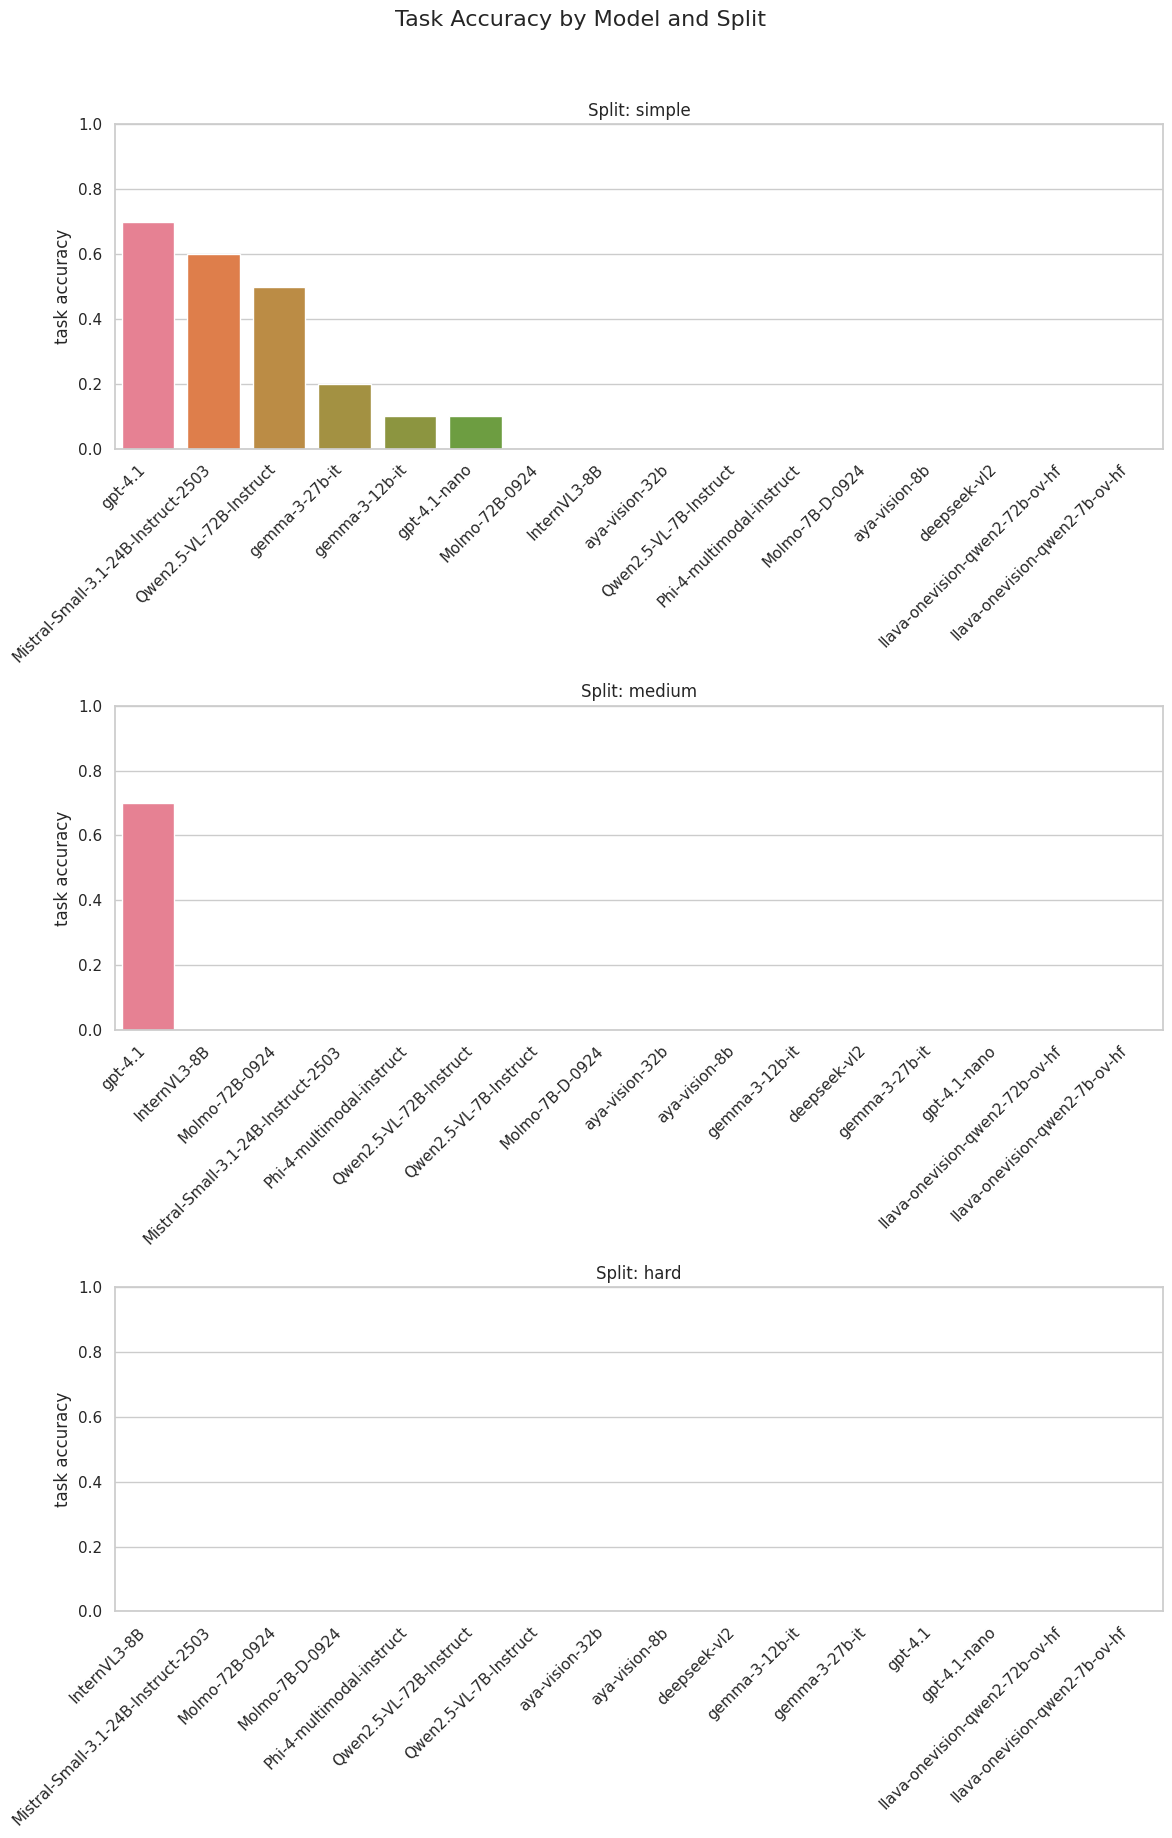

In [22]:
plot_task_accuracy_bar(main_table_predicates_cot)

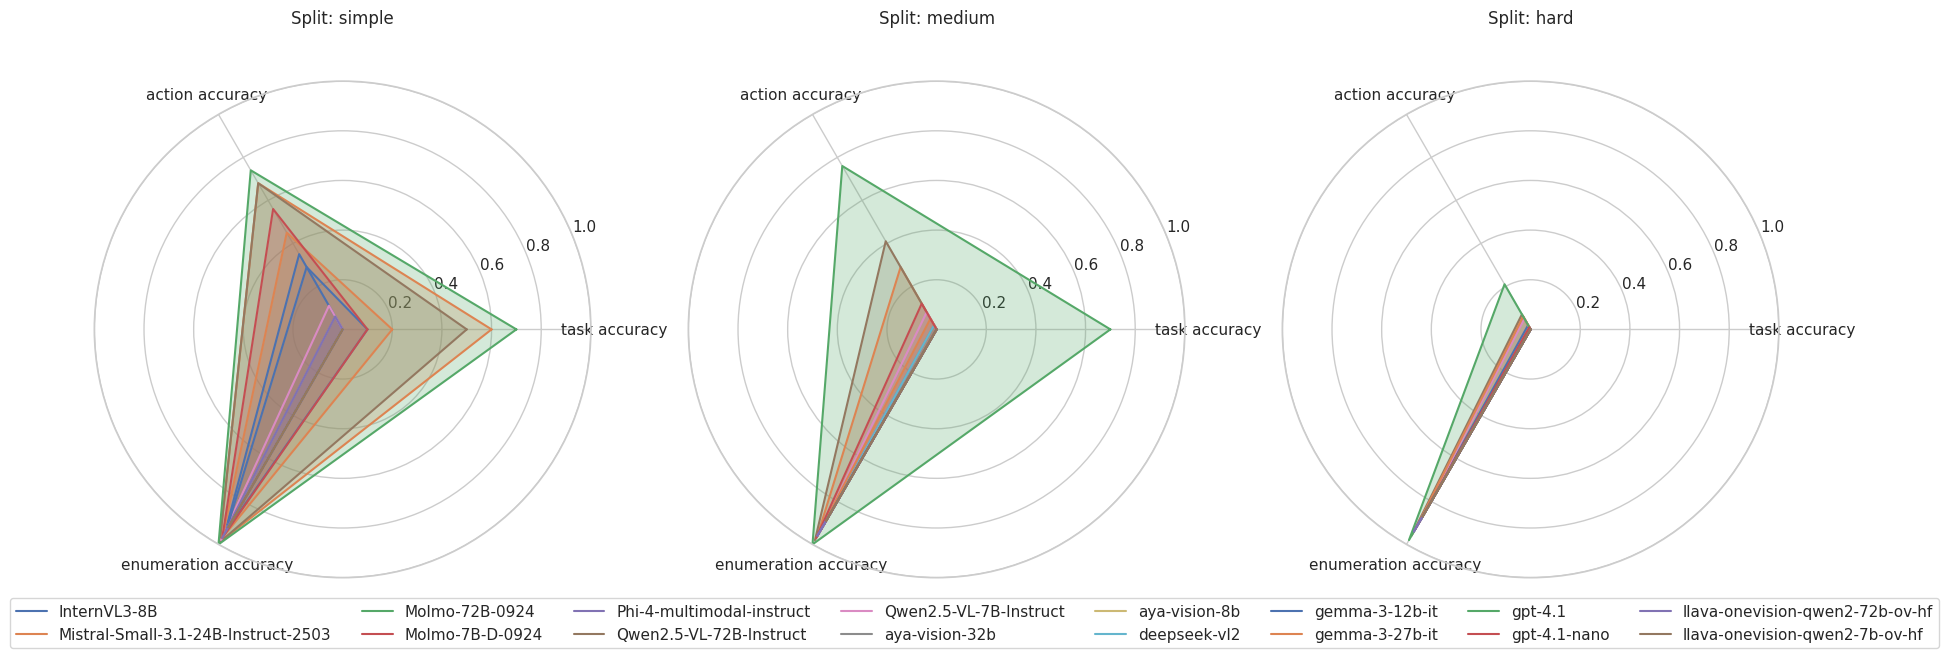

In [23]:
plot_radar_main_table(main_table_predicates_cot, metrics=['task accuracy', 'action accuracy', 'enumeration accuracy'])

/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


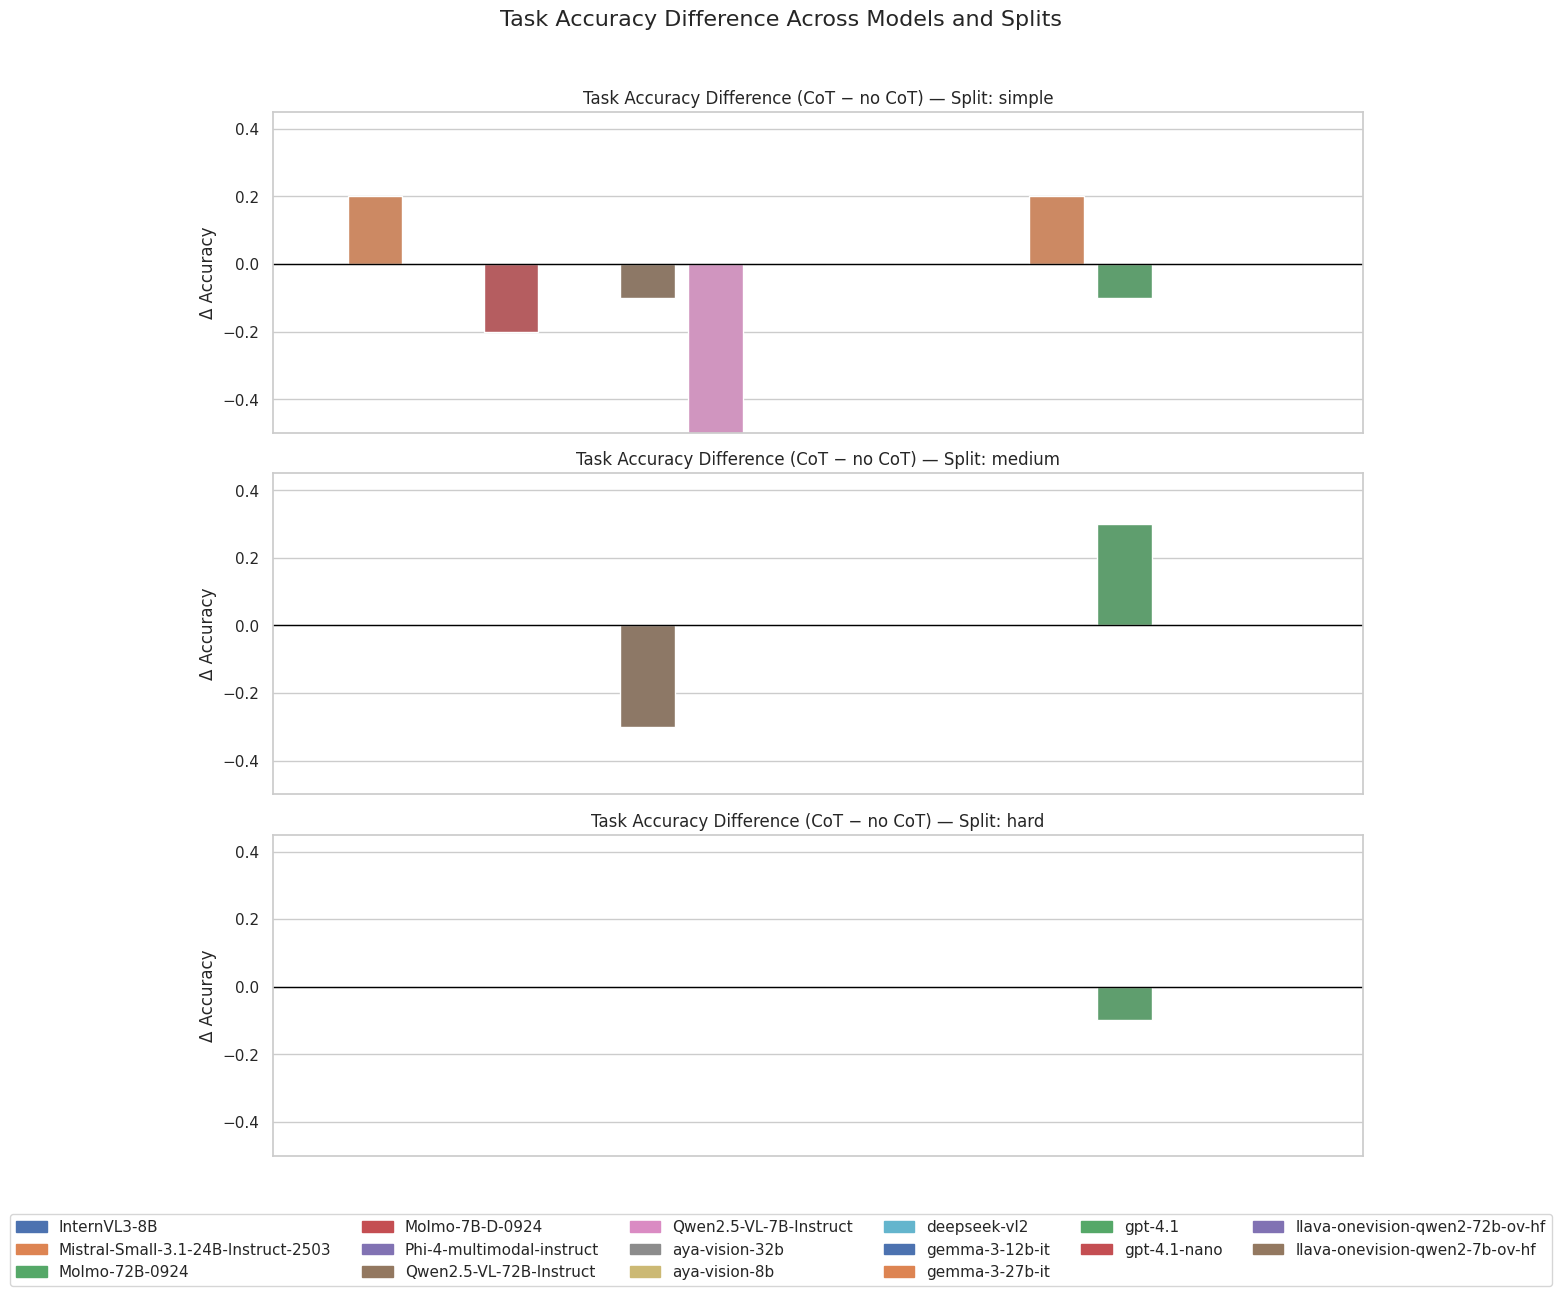

/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


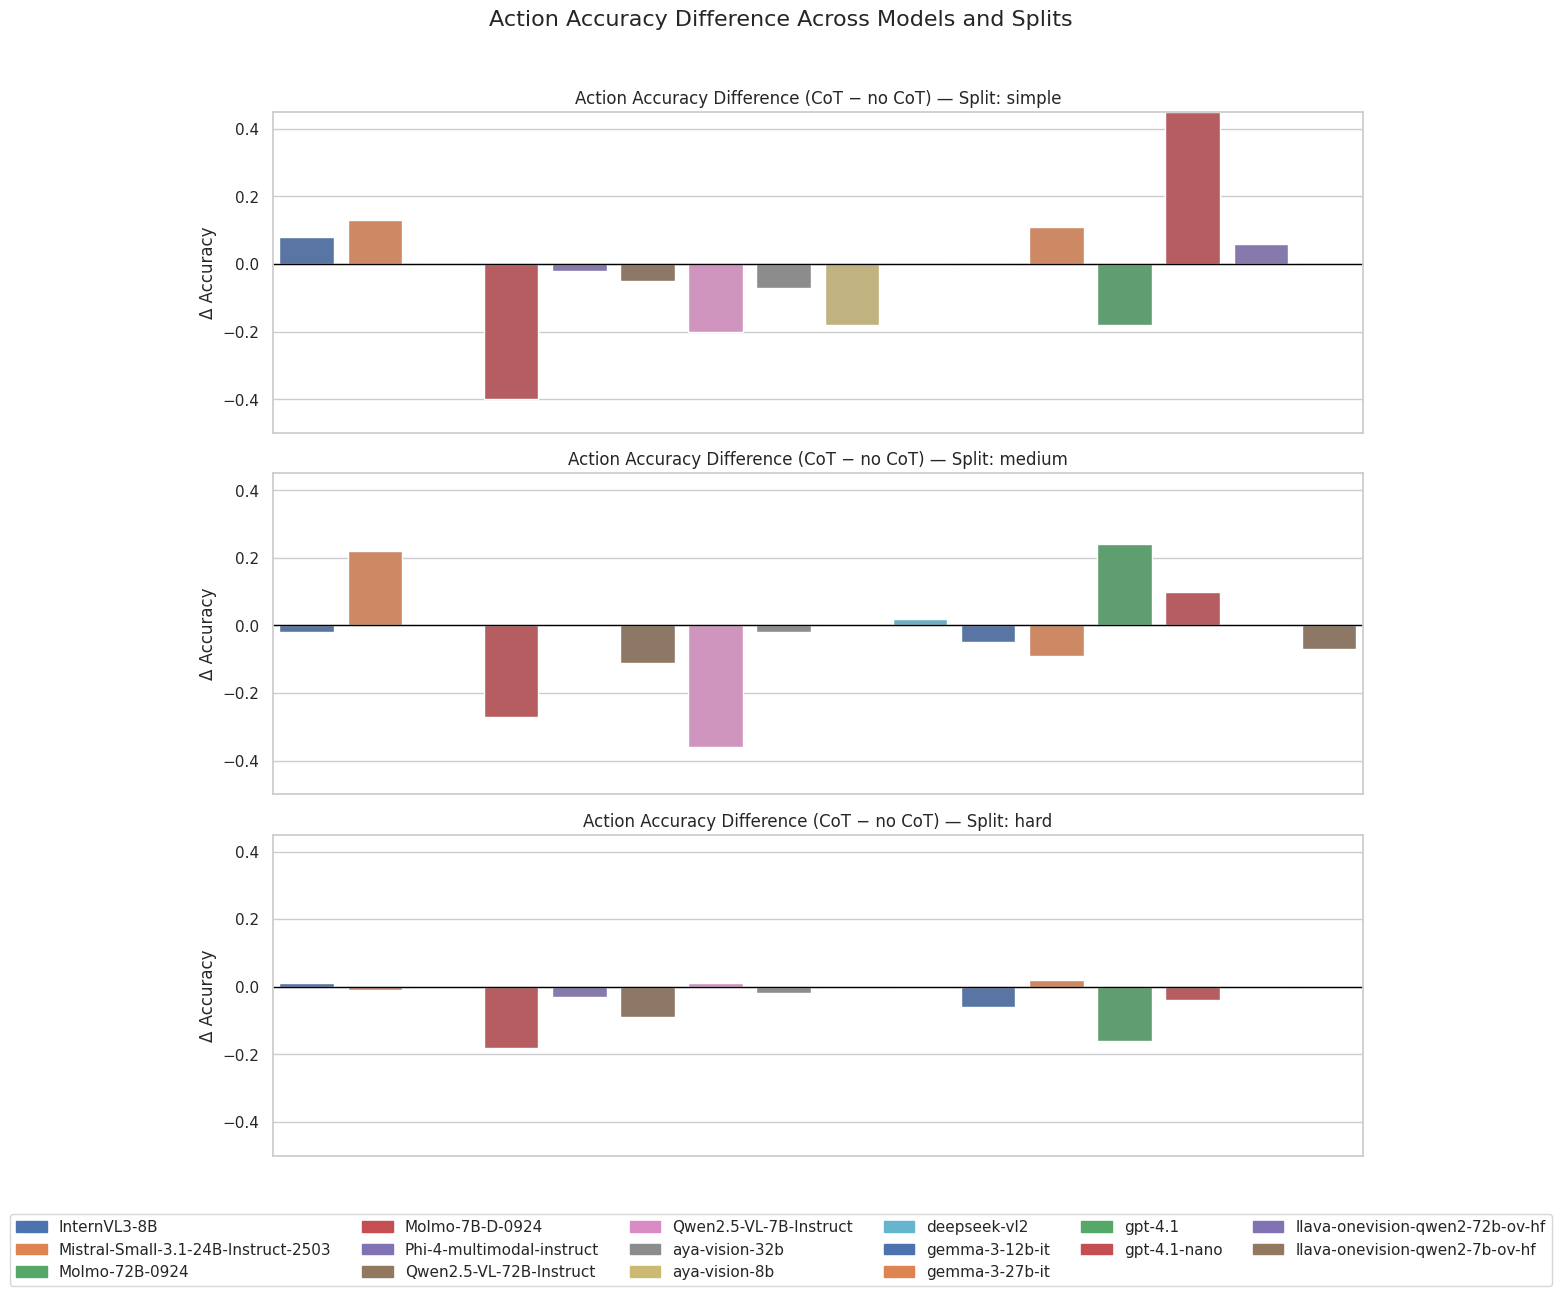

/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2115318/2346290850.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


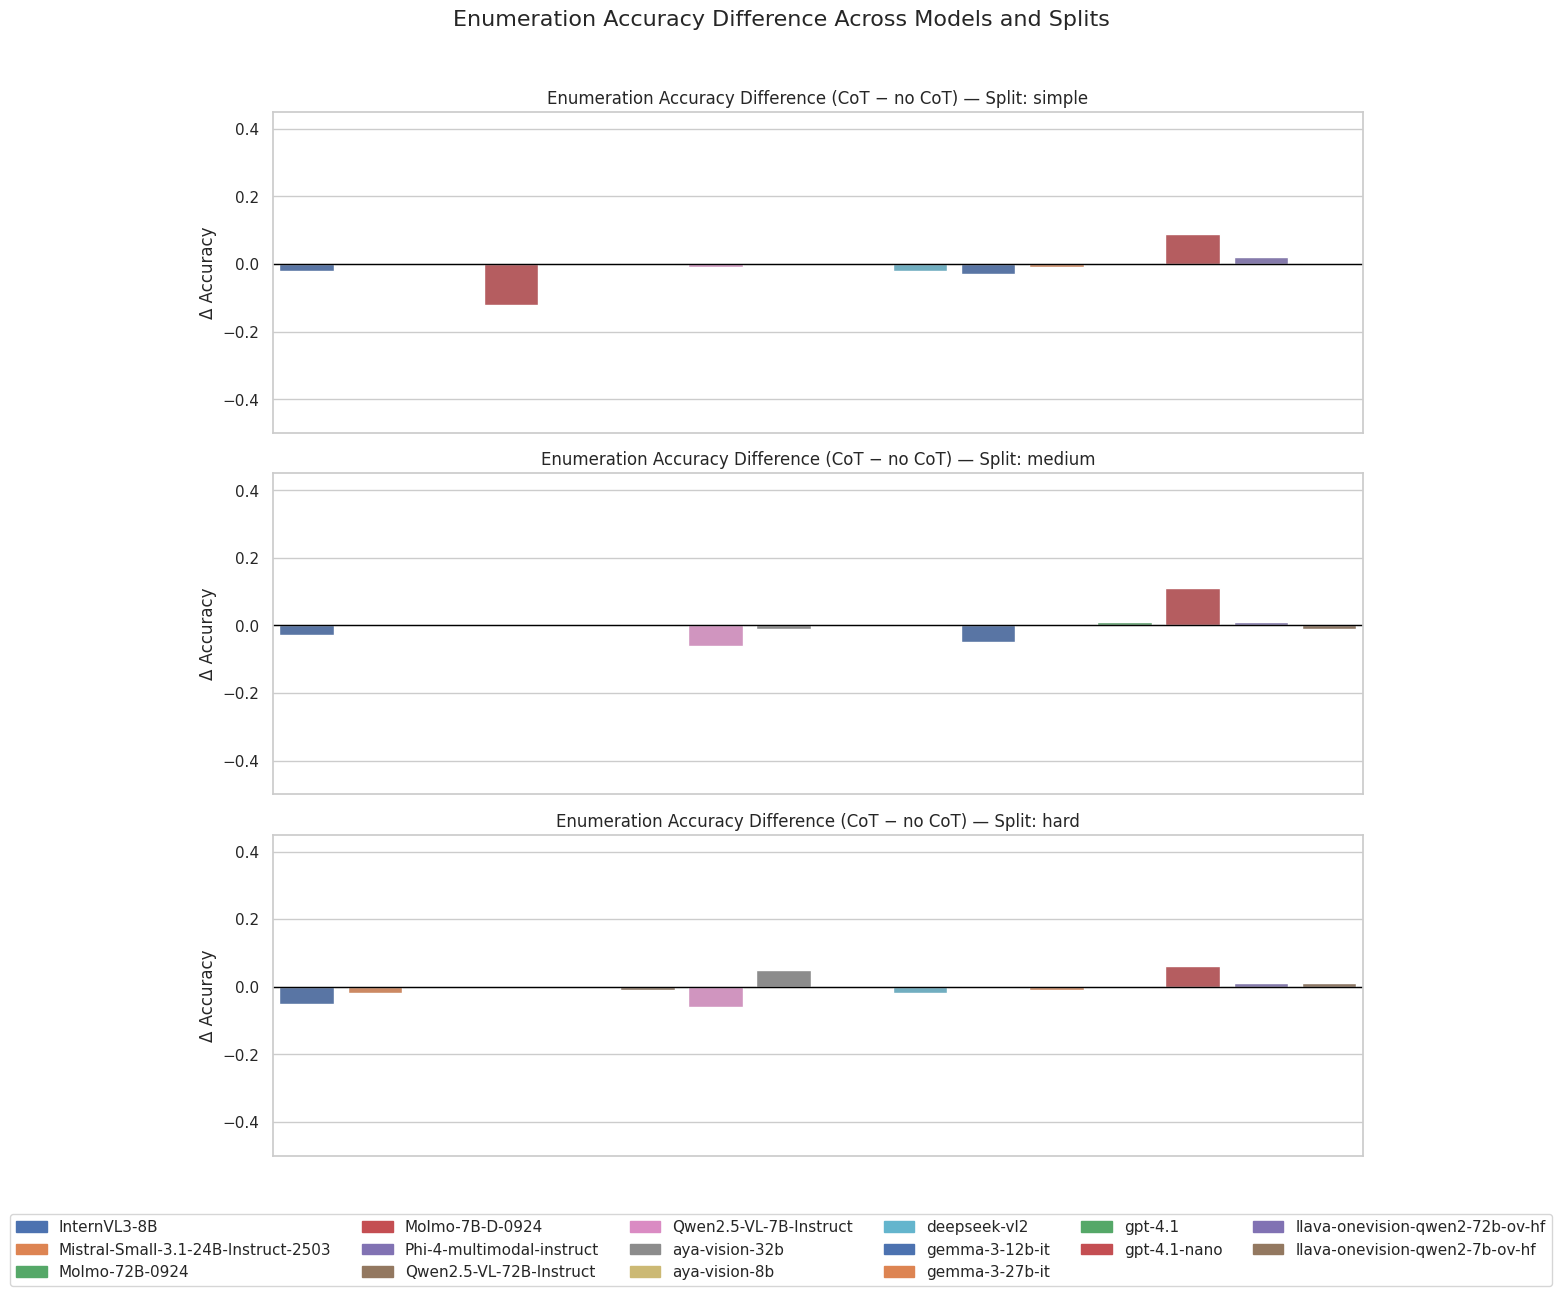

In [24]:
from matplotlib.patches import Patch

# Compute differences between no‐CoT and CoT for each metric
df_no = predicates_main_table[['model','split',
    'task accuracy','action accuracy','enumeration accuracy']]
df_cot = main_table_predicates_cot[['model','split',
    'task accuracy','action accuracy','enumeration accuracy']]
df_diff = pd.merge(df_no, df_cot, on=['model','split'], suffixes=('_no','_cot'))
df_diff['task_diff'] = df_diff['task accuracy_cot'] - df_diff['task accuracy_no']
df_diff['action_diff'] = df_diff['action accuracy_cot'] - df_diff['action accuracy_no']
df_diff['enum_diff'] = df_diff['enumeration accuracy_cot'] - df_diff['enumeration accuracy_no']

max_diff = df_diff[['task_diff','action_diff','enum_diff']].max().max()
min_diff = df_diff[['task_diff','action_diff','enum_diff']].min().min()

# build a consistent color map for models
models = sorted(df_diff['model'].unique())
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_map = {m: palette[i % len(palette)] for i,m in enumerate(models)}

# plot 3×1 grids for each metric
for metric, title in [
    ('task_diff', 'Task Accuracy'),
    ('action_diff', 'Action Accuracy'),
    ('enum_diff', 'Enumeration Accuracy')
]:
    fig, axes = plt.subplots(len(splits), 1, figsize=(12, 4*len(splits)), sharex=True)
    for ax, split in zip(axes, splits):
        df_s = df_diff[df_diff['split']==split]
        sns.barplot(
            data=df_s, x='model', y=metric,
            palette=color_map, ax=ax
        )
        ax.axhline(0, color='black', linewidth=1)
        ax.set_title(f"{title} Difference (CoT − no CoT) — Split: {split}")
        ax.set_ylabel("Δ Accuracy")
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(min_diff, max_diff)

    # add legend mapping colors to models
    handles = [Patch(color=color_map[m], label=m) for m in models]
    fig.legend(
        handles=handles,
        labels=models,
        loc='lower center',
        ncol=int(np.ceil(len(models)/3)),
        bbox_to_anchor=(0.5, -0.05)
    )

    fig.suptitle(f"{title} Difference Across Models and Splits", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

## ViLa

In [25]:
def construct_vila_table(results):
    rows = []
    for split in splits:
        for model, data in results.get(split, {}).items():
            problem_keys = [k for k in data.keys() if isinstance(data[k], dict) and 'actions' in data[k]]
            avg_plan_length = np.mean([len(data[k]['actions']) for k in problem_keys])
            avg_success_plan_length = np.mean([len(data[k]['actions']) for k in problem_keys if data[k]['completed']])
            rows.append({
                'model': model,
                'split': split,
                'avg_plan_length': avg_plan_length,
                'avg_success_plan_length': avg_success_plan_length,
                **data['statistics']
            })
    df = pd.DataFrame(rows)
    df['split'] = pd.Categorical(df['split'], categories=['simple', 'medium', 'hard'], ordered=True)
    df = df.sort_values(by=['model', 'split'])
    return df

vila_main_table = construct_vila_table(vila_results)
vila_main_table

/scratch/work/merlerm1/.conda_envs/predicate_detection/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/work/merlerm1/.conda_envs/predicate_detection/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


model   split  avg_plan_length  \
5         Phi-4-multimodal-instruct  simple              7.0   
20        Phi-4-multimodal-instruct    hard              7.5   
3           Qwen2.5-VL-72B-Instruct  simple              8.5   
12          Qwen2.5-VL-72B-Instruct  medium             17.9   
18          Qwen2.5-VL-72B-Instruct    hard             29.1   
6            Qwen2.5-VL-7B-Instruct  simple             10.1   
13           Qwen2.5-VL-7B-Instruct  medium             16.3   
21           Qwen2.5-VL-7B-Instruct    hard             22.1   
4                    aya-vision-32b  simple              3.9   
19                   aya-vision-32b    hard              4.4   
7                     aya-vision-8b  simple              9.1   
14                    aya-vision-8b  medium             10.5   
22                    aya-vision-8b    hard             15.9   
0                    gemma-3-12b-it  simple              7.8   
9                    gemma-3-12b-it  medium             15.6   
1                    gemma-3-27b-it  simple              8.3   
10                   gemma-3-27b-it  medium             15.4   
16                   gemma-3-27b-it    hard             28.7   
8   llava-onevision-qwen2-72b-ov-hf  simple              0.0   
15  llava-onevision-qwen2-72b-ov-hf  medium              0.0   
23  llava-onevision-qwen2-72b-ov-hf    hard              0.0   
2    llava-onevision-qwen2-7b-ov-hf  simple              0.0   
11   llava-onevision-qwen2-7b-ov-hf  medium              0.0   
17   llava-onevision-qwen2-7b-ov-hf    hard              0.0   

    avg_success_plan_length  total_actions  total_success  total_failed  \
5                  8.000000             70             23            47   
20                      NaN             75              1            74   
3                  5.666667             85             42            43   
12                12.000000            179             64           115   
18                      NaN            291             66           225   
6                 10.000000            101             22            79   
13                      NaN            163             15           148   
21                      NaN            221             38           183   
4                       NaN             39              7            32   
19                      NaN             44              2            42   
7                       NaN             91             11            80   
14                      NaN            105             24            81   
22                      NaN            159             16           143   
0                  7.000000             78             32            46   
9                 20.000000            156             47           109   
1                  8.000000             83             44            39   
10                15.333333            154             63            91   
16                      NaN            287             49           238   
8                       NaN              0              0             0   
15                      NaN              0              0             0   
23                      NaN              0              0             0   
2                       NaN              0              0             0   
11                      NaN              0              0             0   
17                      NaN              0              0             0   

    total_tasks_completed  action_success_rate  action_failure_rate  \
5                       1             0.328571             0.671429   
20                      0             0.013333             0.986667   
3                       3             0.494118             0.505882   
12                      1             0.357542             0.642458   
18                      0             0.226804             0.773196   
6                       1             0.217822             0.782178   
13                      0             0.092025          

/tmp/ipykernel_2115318/503695476.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/503695476.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/503695476.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


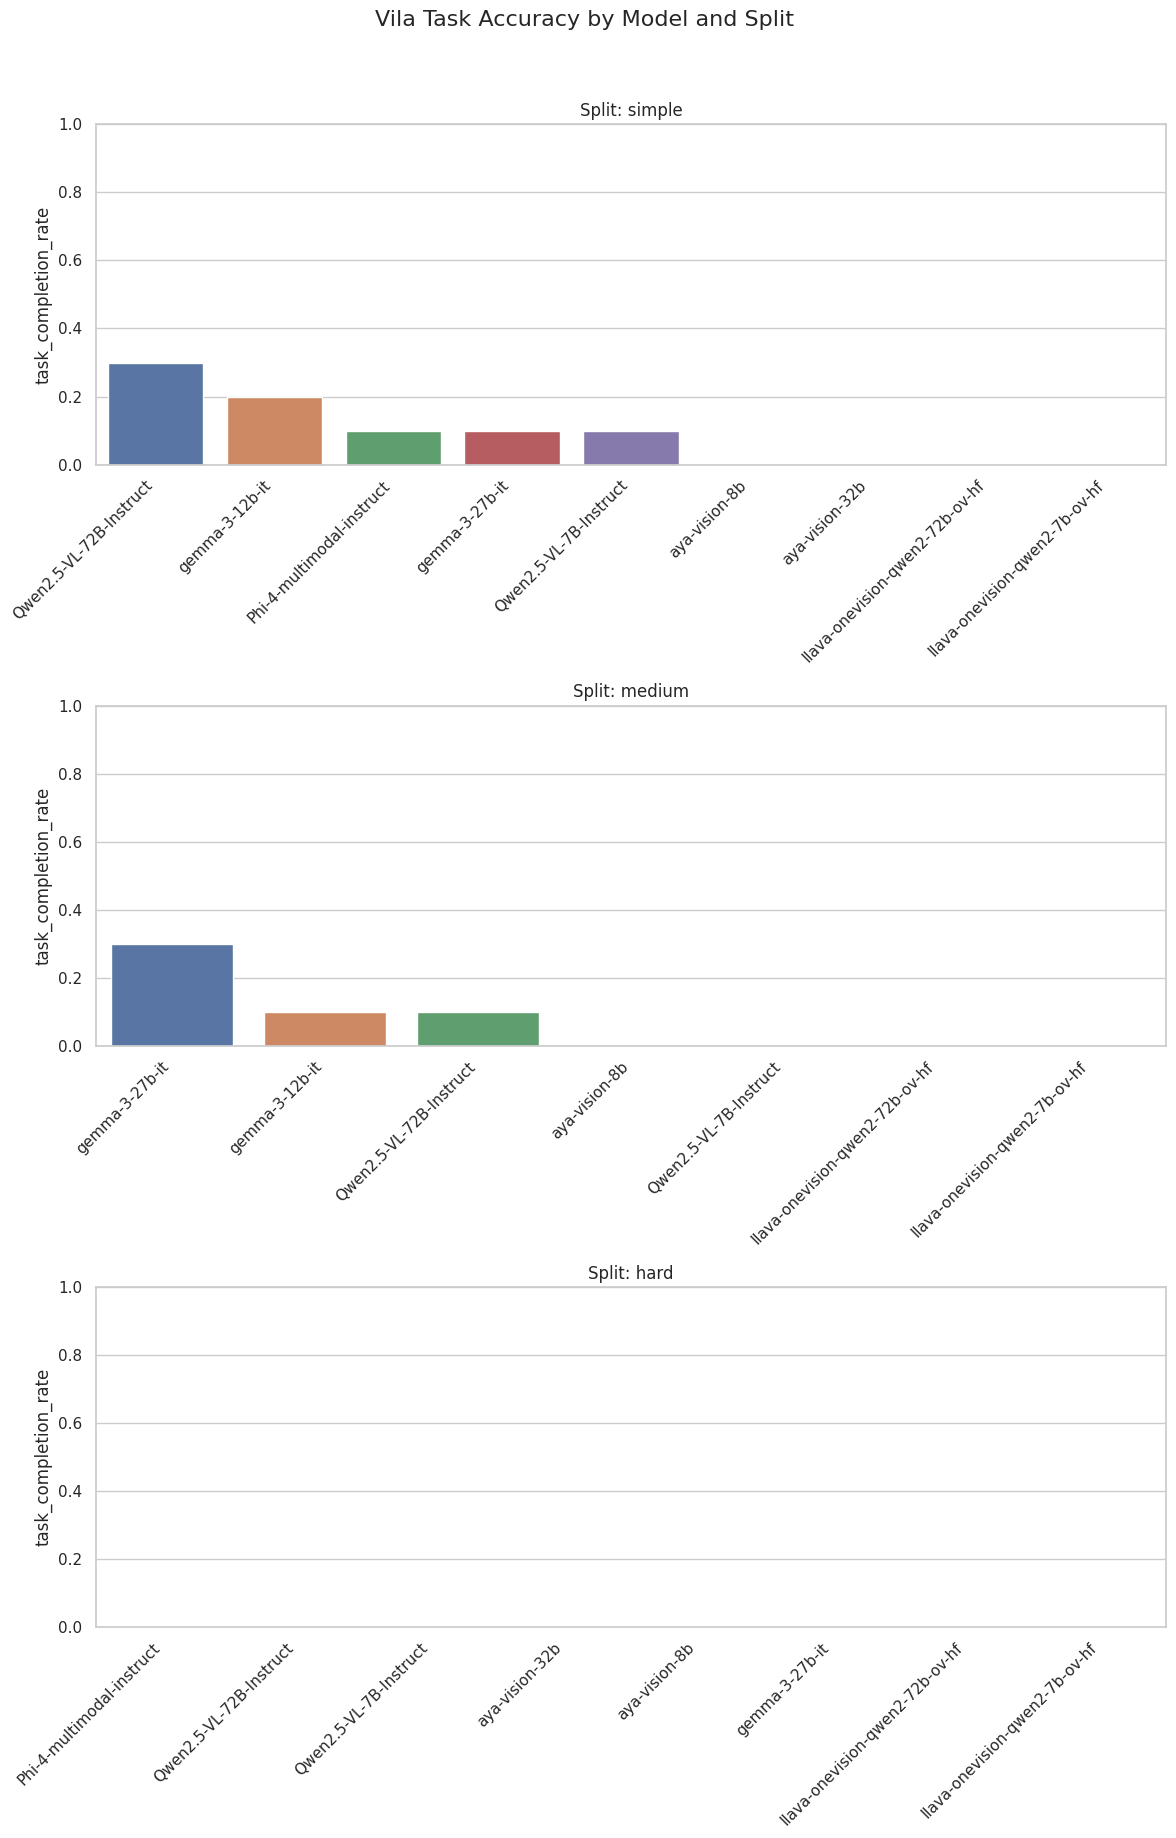

In [26]:
def plot_vila_task_accuracy_bar(main_table):
    fig, axes = plt.subplots(len(splits), 1, figsize=(12, 18), sharey=True)
    for ax, split in zip(axes, splits):
        df_split = main_table[main_table['split'] == split]
        if df_split.empty:
            ax.set_visible(False)
            continue
        df_sorted = df_split.sort_values('task_completion_rate', ascending=False)
        sns.barplot(
            data=df_sorted,
            x='model', y='task_completion_rate',
            hue='model',
            ax=ax
        )
        ax.set_title(f"Split: {split}")
        ax.set_ylim(0, 1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    fig.suptitle("Vila Task Accuracy by Model and Split", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_vila_task_accuracy_bar(vila_main_table)

/tmp/ipykernel_2115318/4135128235.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/4135128235.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/4135128235.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


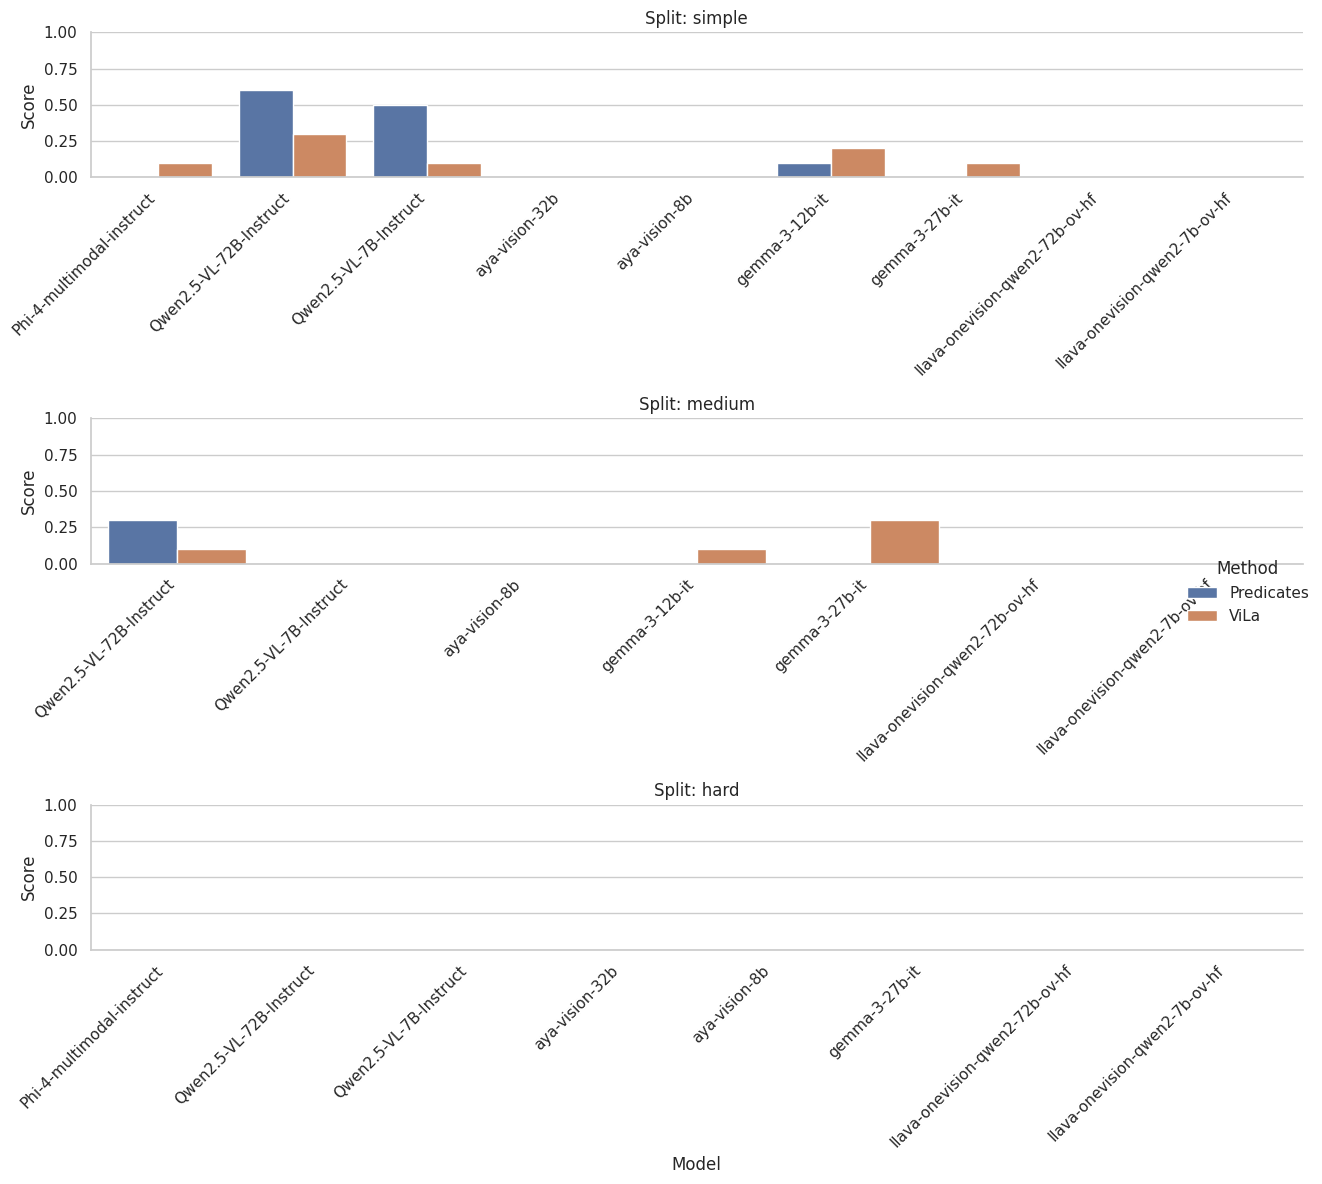

In [27]:
# Compare task accuracy between Predicates and ViLa
df_compare = pd.merge(
    predicates_main_table[['model', 'split', 'task accuracy']],
    vila_main_table[['model', 'split', 'task_completion_rate']],
    on=['model', 'split']
).rename(columns={
    'task accuracy': 'Predicates',
    'task_completion_rate': 'ViLa'
})

df_long = df_compare.melt(
    id_vars=['model', 'split'],
    value_vars=['Predicates', 'ViLa'],
    var_name='Method',
    value_name='Score'
)

sns.set(style="whitegrid")
g = sns.catplot(
    data=df_long,
    x='model', y='Score',
    hue='Method', row='split',
    kind='bar',
    height=4, aspect=3,
    sharey=True,  # keep y shared
    sharex=False  # disable shared x so every facet draws its own ticks
)
g.set_titles("Split: {row_name}")
g.set_axis_labels("Model", "Score")
g.set(ylim=(0, 1))

# ensure every subplot shows its x‐ticks
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Random policy baseline for vila

In [28]:
from viplan.code_helpers import get_logger
from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from unified_planning.io import PDDLReader

import random

In [ ]:
from tqdm import tqdm

def get_env(domain, problem):
    reader = PDDLReader()
    problem = reader.parse_problem(domain, problem)
    logger = get_logger(log_level='error')
    env = BlocksworldSimulator(problem, root_path=ROOT, logger=logger, seed=1, use_gpu_rendering=False)
    return env

def random_policy(domain, problem, max_steps=50, seed=None):
    """
    A random policy that takes random actions until the problem is solved or max_steps is reached.
    """
    env = get_env(domain, problem)
    
    fail_counter = 0
    steps = 0
    
    random.seed(seed)
    
    while not env.goal_reached and steps < max_steps:
        steps += 1
        blocks = env.all_objects['block']
        columns = env.all_objects['column']

        b = str(random.choice(blocks))
        c = str(random.choice(columns))
        action = env._get_specific_action(b, c)
        success, info = env.apply_action(action)
        
        if not success:
            fail_counter += 1

    if env.goal_reached:
        return True, steps, fail_counter
    return False, steps, fail_counter

def get_random_baseline(domain, split, runs_per_problem=100, max_steps=50, seed=None):
    """
    Get the random baseline for a given domain and split.
    """
    problems_folder = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'problems', split)
    problems = [f for f in os.listdir(problems_folder) if f.endswith('.pddl')]
    
    results = {}
    for problem in tqdm(problems, desc=f"Random baseline problems ({split})", unit="problem"):
        results[problem] = []
        problem_path = os.path.join(problems_folder, problem)
        for _ in tqdm(range(runs_per_problem), desc=f"Runs for {problem}", unit="run", leave=False):
            success, steps, fail_counter = random_policy(
                domain, problem_path, max_steps=max_steps, seed=seed
            )
            results[problem].append({
                'success': success,
                'steps': steps,
                'fail_counter': fail_counter
            })
            
    # Compute statistics per problem
    stats_per_problem = {}
    all_success, all_steps, all_fail = [], [], []
    for problem, runs in results.items():
        successes = [r['success'] for r in runs]
        steps = [r['steps'] for r in runs]
        fails = [r['fail_counter'] for r in runs]
        stats_per_problem[problem] = {
            'success_rate': np.mean(successes),
            'steps_mean': np.mean(steps),
            'steps_std': np.std(steps),
            'fail_counter_mean': np.mean(fails),
            'fail_counter_std': np.std(fails),
        }
        all_success.extend(successes)
        all_steps.extend(steps)
        all_fail.extend(fails)

    # Overall statistics
    overall_stats = {
        'success_rate': np.mean(all_success),
        'steps_mean': np.mean(all_steps),
        'steps_std': np.std(all_steps),
        'fail_counter_mean': np.mean(all_fail),
        'fail_counter_std': np.std(all_fail),
    }

    return stats_per_problem, overall_stats

In [30]:
domain_file = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'domain.pddl')

random_baselines = {}
for split in splits:
    max_steps = 10 if split == 'simple' else 20 if split == 'medium' else 30
    stats_per_problem, overall_stats = get_random_baseline(domain_file, split, runs_per_problem=100, max_steps=max_steps, seed=1)
    print(f"Split: {split}")
    print("Overall statistics:")
    print(overall_stats)
    print()
    random_baselines[split] = (overall_stats, stats_per_problem)

Random baseline problems (simple):   0%|          | 0/10 [00:00<?, ?problem/s]

Random baseline problems (simple): 100%|██████████| 10/10 [01:28<00:00,  8.89s/problem]


Split: simple
Overall statistics:
{'success_rate': np.float64(0.0), 'steps_mean': np.float64(10.0), 'steps_std': np.float64(0.0), 'fail_counter_mean': np.float64(4.9), 'fail_counter_std': np.float64(1.3747727084867518)}



Random baseline problems (medium): 100%|██████████| 10/10 [01:46<00:00, 10.66s/problem]


Split: medium
Overall statistics:
{'success_rate': np.float64(0.0), 'steps_mean': np.float64(20.0), 'steps_std': np.float64(0.0), 'fail_counter_mean': np.float64(11.8), 'fail_counter_std': np.float64(2.2715633383201093)}



Random baseline problems (hard): 100%|██████████| 10/10 [01:52<00:00, 11.22s/problem]

Split: hard
Overall statistics:
{'success_rate': np.float64(0.0), 'steps_mean': np.float64(30.0), 'steps_std': np.float64(0.0), 'fail_counter_mean': np.float64(19.5), 'fail_counter_std': np.float64(2.1095023109728985)}



/tmp/ipykernel_2115318/2814575144.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/2814575144.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/2814575144.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


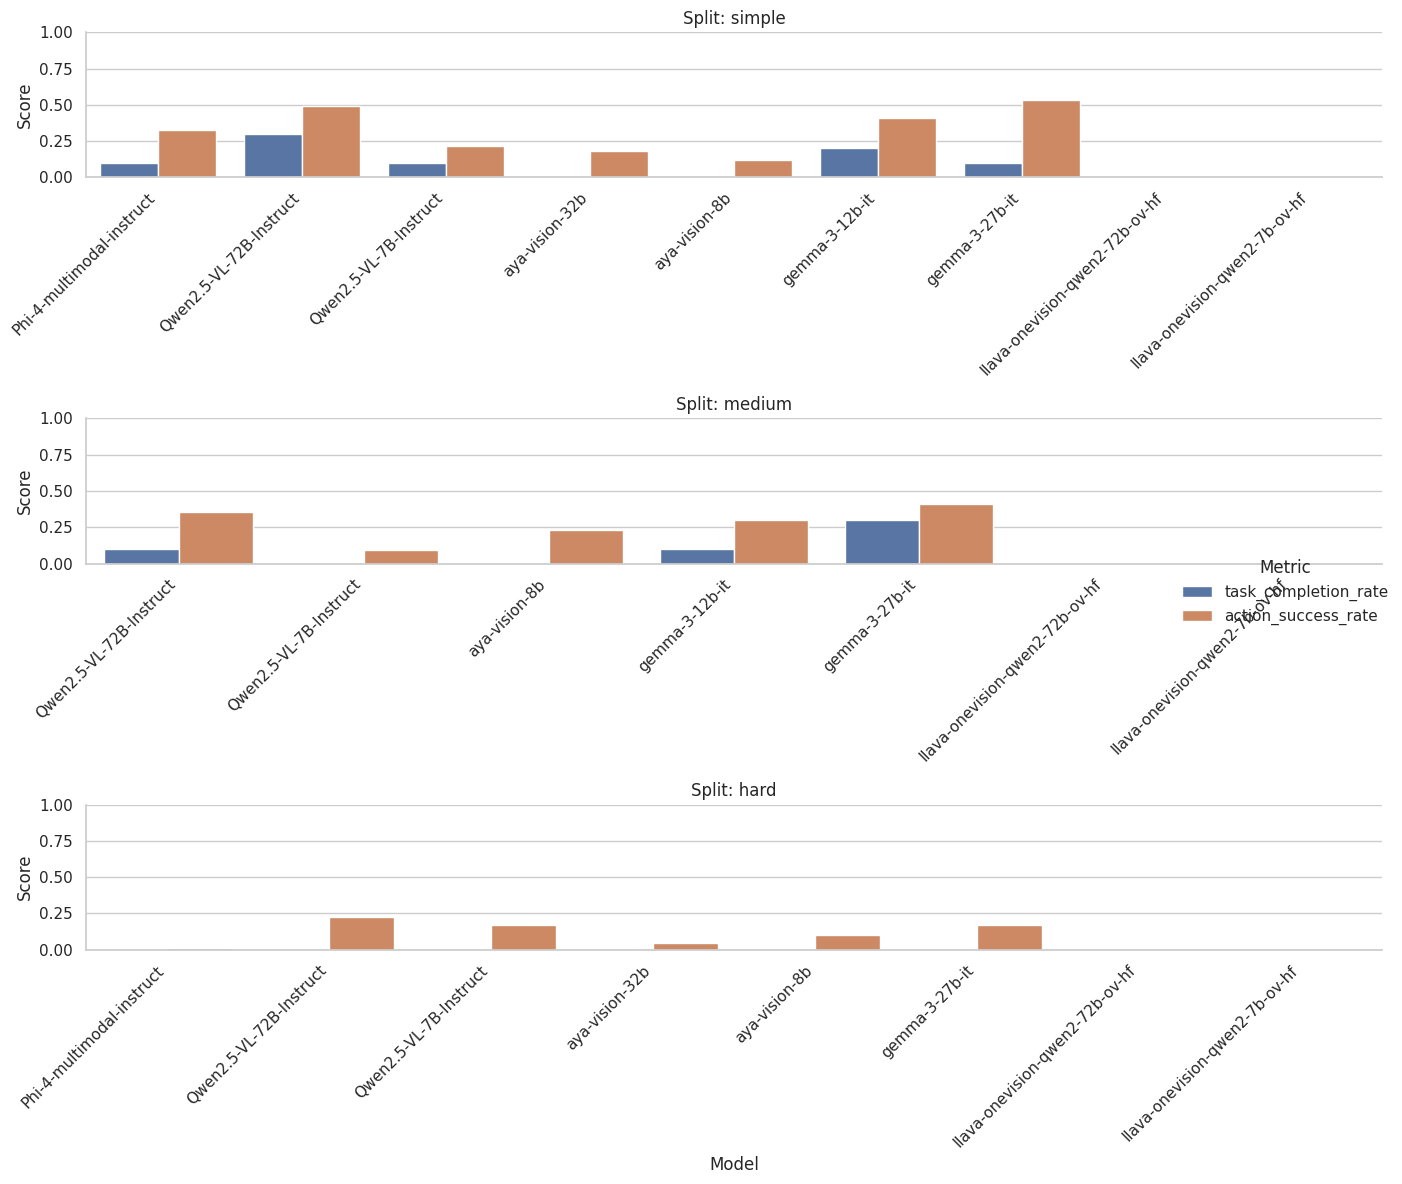

In [31]:
# Plot Vila table showing both task_completion_rate and action_success_rate
df_vila_long = vila_main_table.melt(
    id_vars=['model', 'split'],
    value_vars=['task_completion_rate', 'action_success_rate'],
    var_name='Metric',
    value_name='Score'
)

sns.set(style="whitegrid")
g = sns.catplot(
    data=df_vila_long,
    x='model', y='Score',
    hue='Metric', row='split',
    kind='bar',
    height=4, aspect=3,
    sharey=True, sharex=False
)
g.set_titles("Split: {row_name}")
g.set_axis_labels("Model", "Score")
g.set(ylim=(0, 1))

# rotate x‑labels for readability
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelbottom=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

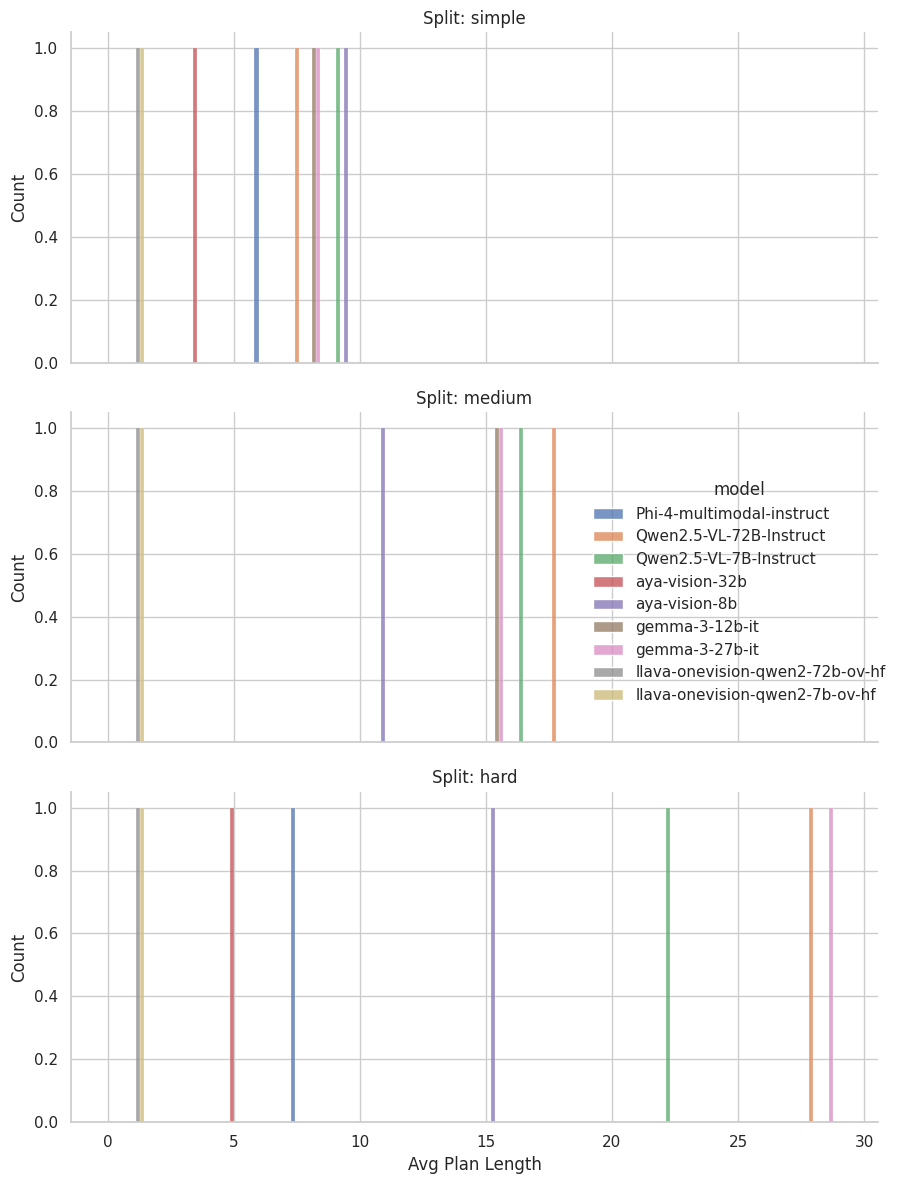

In [32]:
# Histogram of average plan length by model and split (vertical facets)
sns.set(style="whitegrid")
g = sns.displot(
    data=vila_main_table,
    x="avg_plan_length",
    hue="model",
    row="split",
    kind="hist",
    height=4,
    aspect=1.5,
    multiple="dodge",
    bins=20
)
g.set_axis_labels("Avg Plan Length", "Count")
g.set_titles("Split: {row_name}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2115318/190742630.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/190742630.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2115318/190742630.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


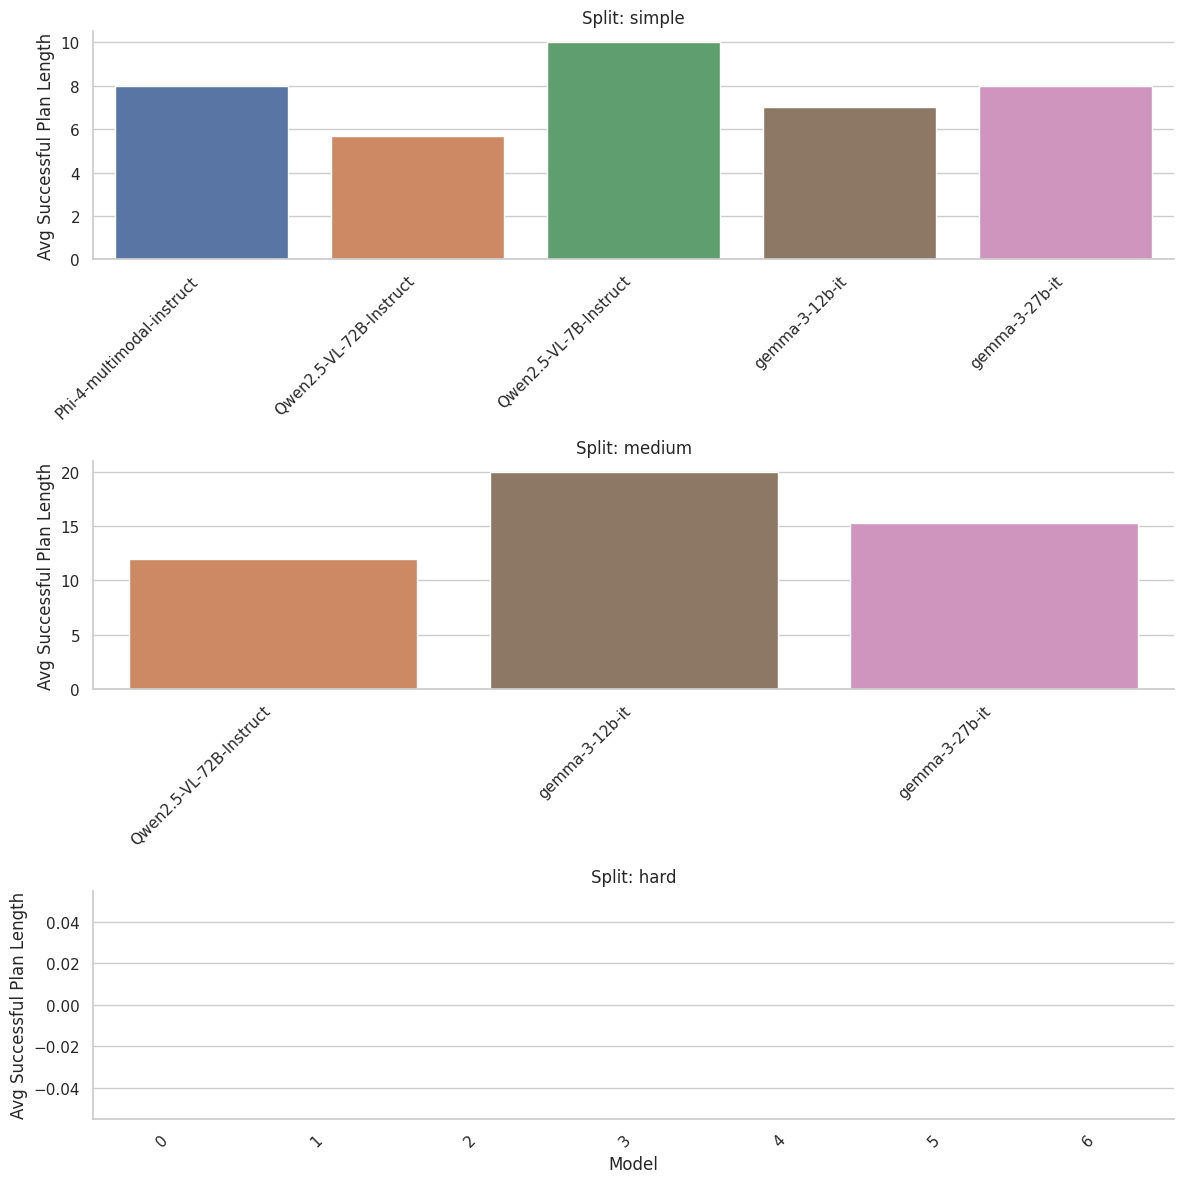

In [33]:
# Compare average successful plan lengths by model and split
sns.set(style="whitegrid")
g = sns.catplot(
    data=vila_main_table,
    x='model',
    y='avg_success_plan_length',
    hue='model',
    row='split',
    kind='bar',
    height=4,
    aspect=3,
    sharey=False,
    sharex=False
)
g.set_titles("Split: {row_name}")
g.set_axis_labels("Model", "Avg Successful Plan Length")
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()